In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings
import os
from pathlib import Path
from pydub import AudioSegment

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/3533495058.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
import os
from pathlib import Path
import pandas as pd

# Define dataset path
dataset_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/")
train_path = dataset_path / "train_5sec"

# Function to traverse directories and map file information to labels
def traverse_and_map(directory, label):
    audio_files = []
    labels = []
    start_times = []
    end_times = []
    
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return pd.DataFrame()  # Return empty DataFrame if directory doesn't exist
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Prepend full dataset path to the file path
                audio_path = dataset_path / Path(root).relative_to(dataset_path) / file
                audio_files.append(str(audio_path))
                labels.append(label)
                start_times.append(0.0)  # Fixed start time
                end_times.append(5.0)   # Fixed end time

    # Create DataFrame for the current directory
    data = {
        "file": audio_files,
        "start_time": start_times,
        "end_time": end_times,
        "A": labels
    }
    return pd.DataFrame(data)

# Initialize a dictionary to hold DataFrames for each training size
labels_trains = {}

# Iterate over each train size folder
if train_path.exists():
    for train_size_dir in train_path.iterdir():
        if train_size_dir.is_dir():  # Ensure it's a directory
            training_size = train_size_dir.name  # Get the name of the training size directory

            # Process `pos` and `neg` subdirectories
            pos_dir = train_size_dir / "pos"
            neg_dir = train_size_dir / "neg"
            df_pos = traverse_and_map(pos_dir, 1)  # 1 for "pos" files
            df_neg = traverse_and_map(neg_dir, 0)  # 0 for "negative" files

            # Combine the DataFrames for `pos` and `neg`
            combined_df = pd.concat([df_pos, df_neg], ignore_index=True)

            # Set MultiIndex with 'file', 'start_time', and 'end_time'
            combined_df.set_index(["file", "start_time", "end_time"], inplace=True)

            # Rename the only column to "A"
            combined_df.columns = ['A']

            # Store the DataFrame in the dictionary
            labels_trains[training_size] = combined_df

            # Optionally, save each DataFrame to a CSV file
            output_path = dataset_path / f"labels_trains_{training_size}.csv"
            combined_df.to_csv(output_path)
            print(f"DataFrame saved for training size {training_size}: {output_path}")
else:
    print(f"Train path does not exist: {train_path}")

# Display the DataFrames for verification
for training_size, df in labels_trains.items():
    print(f"\nDataFrame for training size {training_size}:")
    print(df.head())


DataFrame saved for training size train_size_150: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/labels_trains_train_size_150.csv
DataFrame saved for training size train_size_25: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/labels_trains_train_size_25.csv
DataFrame saved for training size train_size_300: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/labels_trains_train_size_300.csv
DataFrame saved for training size train_size_275: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/labels_trains_train_size_275.csv
DataFrame saved for training size train_size_250: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/labels_trains_train_size_250.csv
DataFrame saved for training size train_size_175: /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/labels_trains_train_size_175.csv


Processing data for training set

In [4]:
labels_trains['train_size_150'].head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_285.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_520.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_65.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_71.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_722.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_656.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_118.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_497.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/train_5sec/train_size_150/pos/t-11127057_440.wav,0.0,5.0,1


Prepare audio Data

Step 1: Train shallow classifier on Perch embeddings

In [5]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


Step 2: Generate embeddings on the training and validation data

Training size 25

In [6]:
emb_train_25 = model.embed(labels_trains['train_size_25'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [7]:
csv_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/test_5sec/test_dataset_5sec.csv")
audio_file_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/test_5sec/test_dataset_5sec.wav")
output_folder = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/test_5sec/clips")
output_csv_dir = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/test_5sec/")
output_csv = output_csv_dir / "processed_test_dataset_5sec.csv"

# Ensure the output directories exist
output_folder.mkdir(parents=True, exist_ok=True)
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file
df_csv = pd.read_csv(csv_path)

# Determine label based on conditions
df_csv["A"] = df_csv.apply(
    lambda row: 1 if row["label"] == 1 and row["Annotation"] == "PCF" else 0, axis=1
)

# Load the audio file
audio = AudioSegment.from_file(audio_file_path)

# Initialize lists for DataFrame creation
file_paths = []
start_times = []
end_times = []
labels = []

# Partition the audio file into 5-second clips based on CSV
for index, row in df_csv.iterrows():
    start_time = index * 5 * 1000  # in milliseconds
    end_time = start_time + 5 * 1000  # 5 seconds later

    # Extract clip
    clip = audio[start_time:end_time]

    # Save clip to the output folder
    #WT does not have unique row identifier filename column
    filename = row["filename"]
    clip_path = output_folder / filename
    clip.export(clip_path, format="wav")

    # Add details to lists
    file_paths.append(str(clip_path))
    start_times.append(0.0)  
    end_times.append(5.0)  
    labels.append(row["A"])

# Create the DataFrame
df_processed = pd.DataFrame({
    "file": file_paths,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels
})
df_processed.set_index(["file", "start_time", "end_time"], inplace=True)
df_processed.columns = ['A']
# Save the DataFrame to a CSV file
df_processed.to_csv(output_csv, index=False)

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/873706465.py:20: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/test_5sec/test_dataset_5sec.wav'>
  audio = AudioSegment.from_file(audio_file_path)
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/873706465.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/test_5sec/clips/t-11127057_34.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/873706465.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/pacific_chorus_frog_5sec/test_5sec/clips/t-11127057_755.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/873706465.py:40: ResourceWarning: u

In [8]:
labels_val = df_processed

In [9]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [10]:
emb_train_25 = torch.tensor(emb_train_25, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_25.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_25 = emb_train_25.view(emb_train_25.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_25: {emb_train_25.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([50, 512])
Reshaped emb_train_25: torch.Size([50, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [11]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [12]:
emb_train_25 = emb_train_25.repeat(1, 3, 1, 1)  # Duplicate to 3 channels
emb_val = emb_val.repeat(1, 3, 1, 1)

In [13]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [16]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [17]:
quick_fit(model.network, emb_train_25, labels_trains['train_size_25'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 3.117222877335735e-05, Val Loss: nan
val AU ROC: nan
val MAP: nan


KeyboardInterrupt: 

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/1842857064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5640888888888889

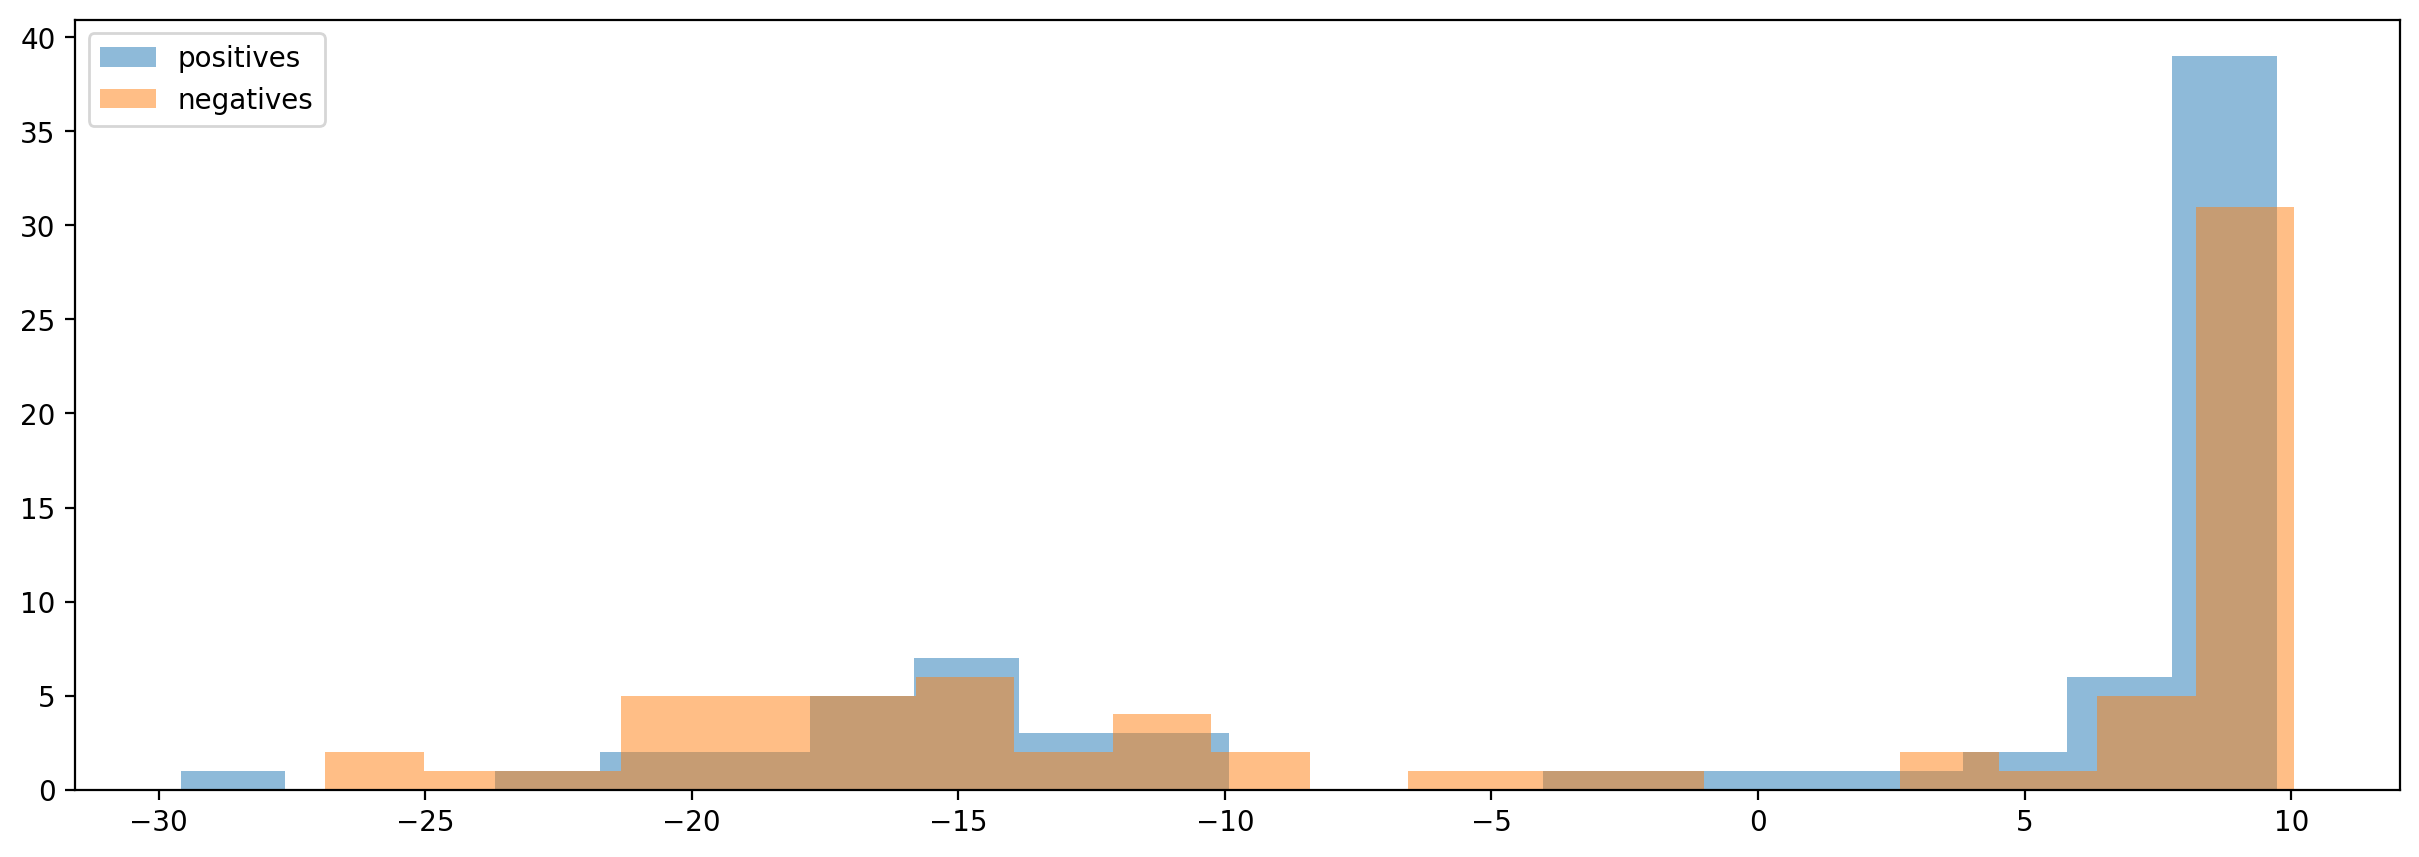

In [18]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_25 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_25

Training size 50

In [19]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [20]:
emb_train_50 = model.embed(labels_trains['train_size_50'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [21]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [22]:
emb_train_50 = torch.tensor(emb_train_50, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_50.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_50 = emb_train_50.view(emb_train_50.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_50: {emb_train_50.shape}")

Original shape of emb_train: torch.Size([100, 512])
Reshaped emb_train_50: torch.Size([100, 1, 32, 16])


In [23]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [24]:
emb_train_50 = emb_train_50.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [25]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [26]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [27]:
quick_fit(model.network, emb_train_50, labels_trains['train_size_50'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 6.607418617932126e-05, Val Loss: 3.9200174808502197
val AU ROC: 0.616
val MAP: 0.616
Epoch 200/1000, Loss: 4.051028372487053e-05, Val Loss: 3.994278907775879
val AU ROC: 0.613
val MAP: 0.613
Epoch 300/1000, Loss: 2.855987986549735e-05, Val Loss: 4.057531356811523
val AU ROC: 0.605
val MAP: 0.605
Epoch 400/1000, Loss: 2.15993986785179e-05, Val Loss: 4.1064934730529785
val AU ROC: 0.601
val MAP: 0.601
Epoch 500/1000, Loss: 1.7060099708032794e-05, Val Loss: 4.155646324157715
val AU ROC: 0.596
val MAP: 0.596
Epoch 600/1000, Loss: 1.3860350009053946e-05, Val Loss: 4.201499938964844
val AU ROC: 0.592
val MAP: 0.592
Epoch 700/1000, Loss: 1.1545008419489022e-05, Val Loss: 4.24437952041626
val AU ROC: 0.591
val MAP: 0.591
Epoch 800/1000, Loss: 9.771939403435681e-06, Val Loss: 4.2834930419921875
val AU ROC: 0.588
val MAP: 0.588
Epoch 900/1000, Loss: 8.332173820235766e-06, Val Loss: 4.319417476654053
val AU ROC: 0.588
val MAP: 0.588
Epoch 1000/1000, Loss: 7.205793735920452e-

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/2687331274.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5662222222222222

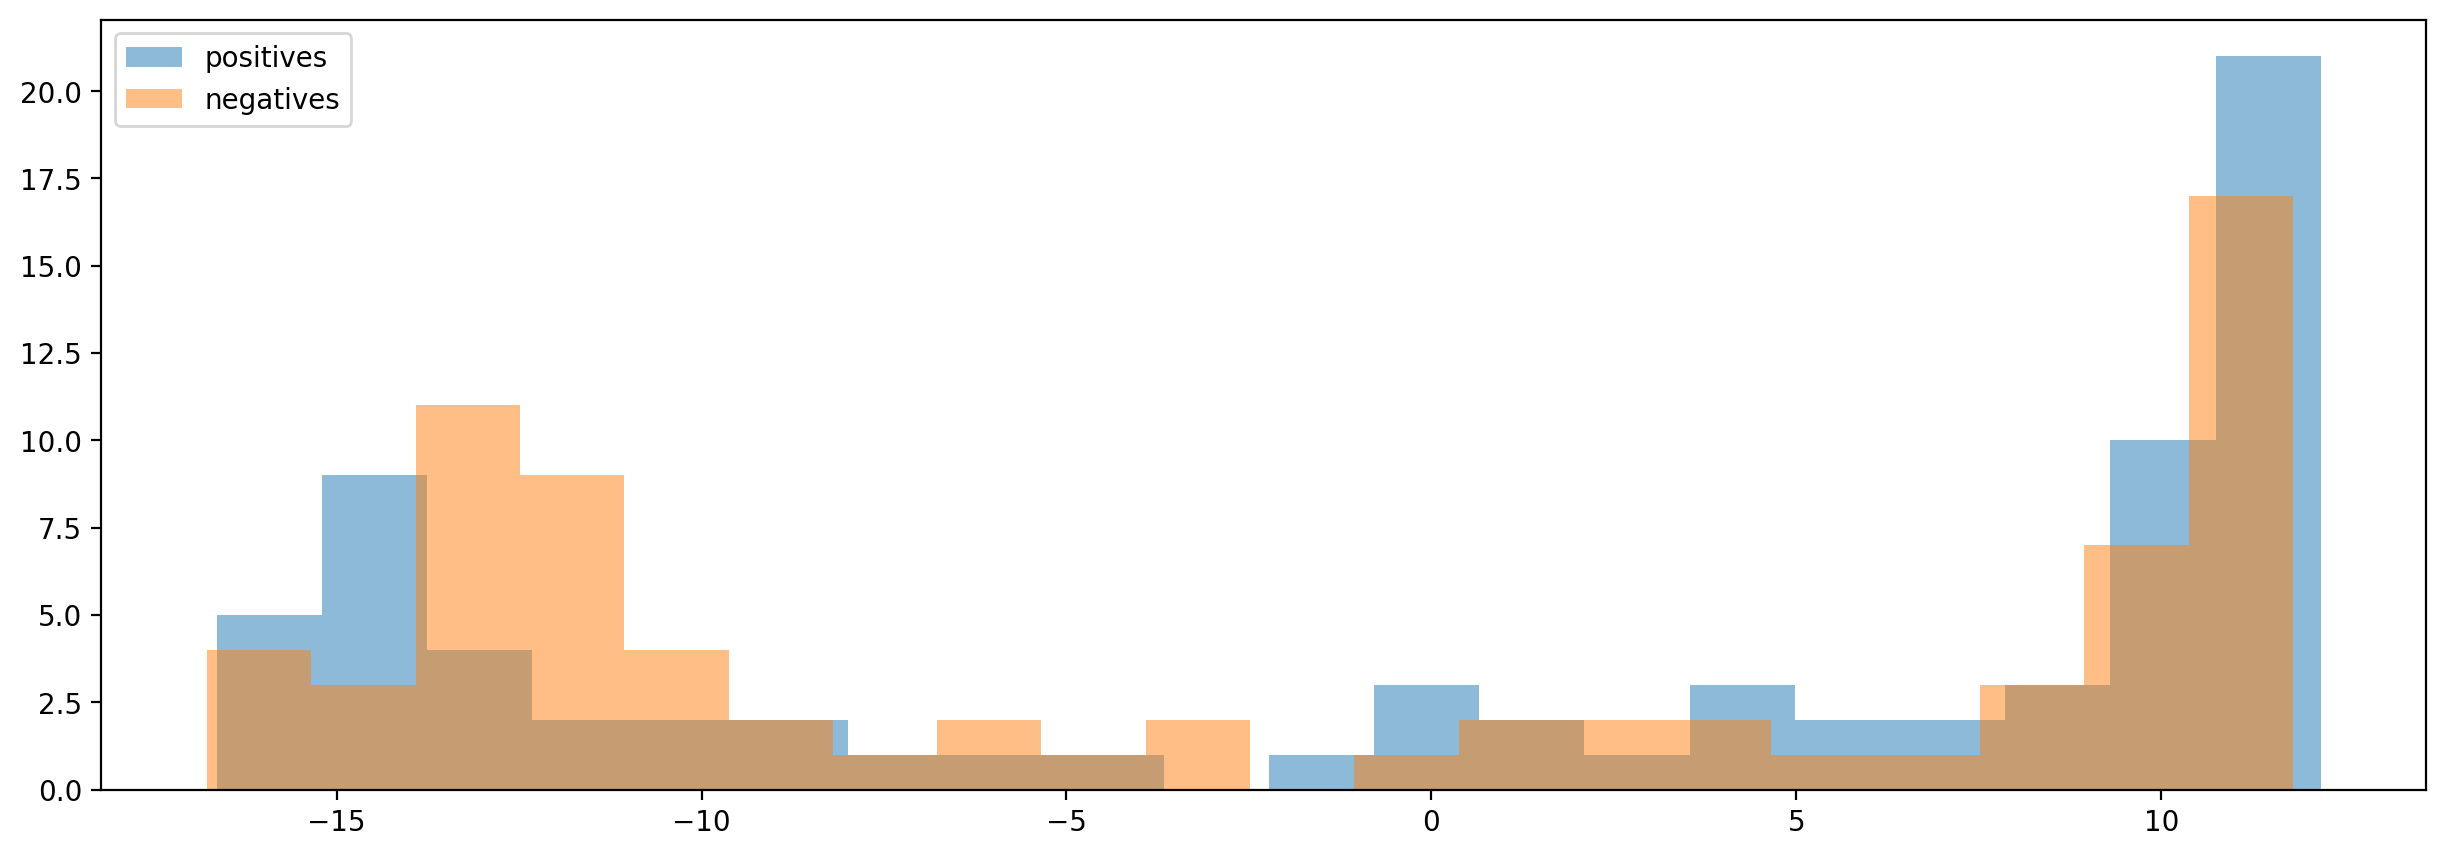

In [28]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_50 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_50

Training size 75

In [29]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [30]:
emb_train_75 = model.embed(labels_trains['train_size_75'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [31]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [32]:
emb_train_75 = torch.tensor(emb_train_75, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_75.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_75 = emb_train_75.view(emb_train_75.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_75: {emb_train_75.shape}")

Original shape of emb_train: torch.Size([150, 512])
Reshaped emb_train_75: torch.Size([150, 1, 32, 16])


In [33]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [34]:
emb_train_75 = emb_train_75.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [35]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [36]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [37]:
quick_fit(model.network, emb_train_75, labels_trains['train_size_75'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 5.115586827741936e-05, Val Loss: 4.404448986053467
val AU ROC: 0.611
val MAP: 0.611
Epoch 200/1000, Loss: 3.2199557608691975e-05, Val Loss: 4.484011650085449
val AU ROC: 0.608
val MAP: 0.608
Epoch 300/1000, Loss: 2.27580894716084e-05, Val Loss: 4.545475959777832
val AU ROC: 0.608
val MAP: 0.608
Epoch 400/1000, Loss: 1.703498128335923e-05, Val Loss: 4.589665412902832
val AU ROC: 0.612
val MAP: 0.612
Epoch 500/1000, Loss: 1.3285580280353315e-05, Val Loss: 4.626887798309326
val AU ROC: 0.617
val MAP: 0.617
Epoch 600/1000, Loss: 1.0674794793885667e-05, Val Loss: 4.664400100708008
val AU ROC: 0.620
val MAP: 0.620
Epoch 700/1000, Loss: 8.747532774577849e-06, Val Loss: 4.697035312652588
val AU ROC: 0.623
val MAP: 0.623
Epoch 800/1000, Loss: 7.299235221580602e-06, Val Loss: 4.725468158721924
val AU ROC: 0.624
val MAP: 0.624
Epoch 900/1000, Loss: 6.178625426400686e-06, Val Loss: 4.751963138580322
val AU ROC: 0.625
val MAP: 0.625
Epoch 1000/1000, Loss: 5.287653493724065e-06

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/3191350587.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


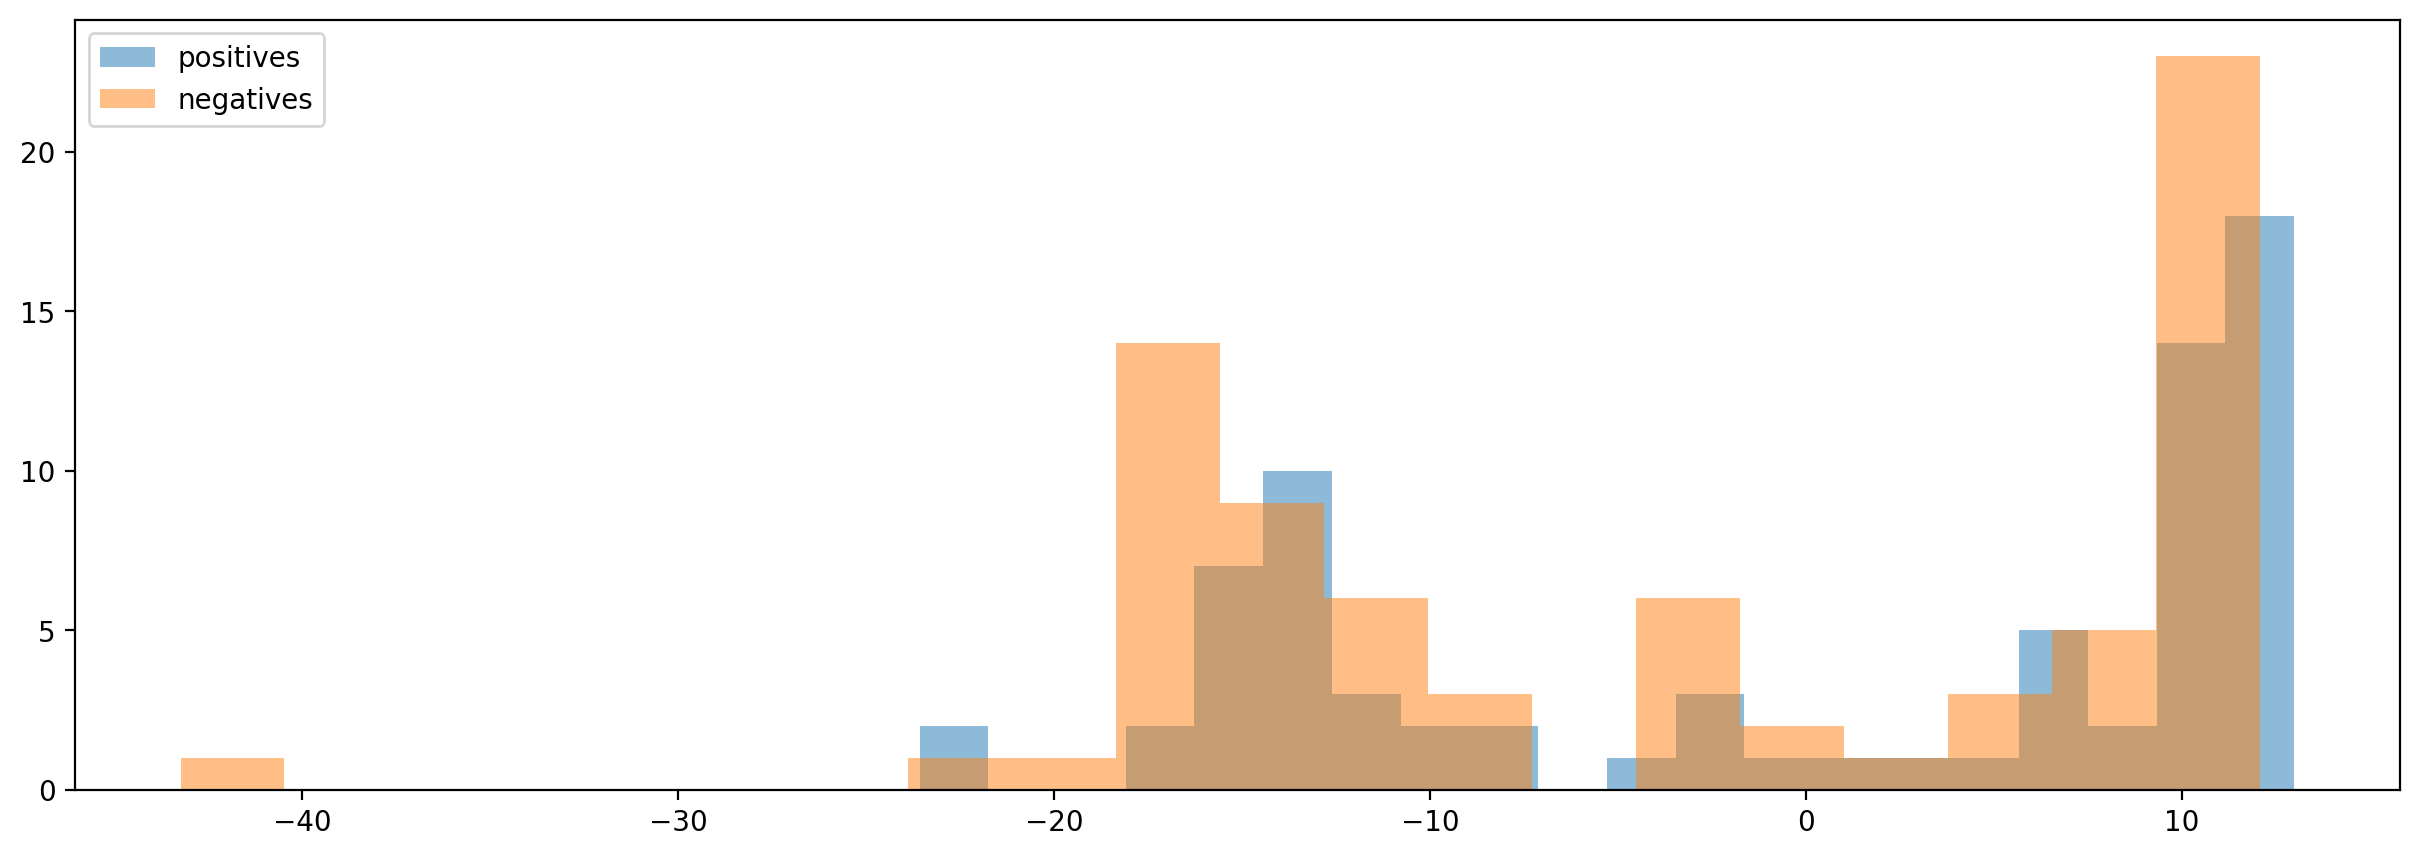

In [38]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_75 = roc_auc_score(labels_val.values,preds,average=None)

In [39]:
roc_auc_score_75

0.6042666666666666

Training size 100

In [40]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [41]:
emb_train_100 = model.embed(labels_trains['train_size_100'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/7 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [42]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [43]:
emb_train_100 = torch.tensor(emb_train_100, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_100.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_100 = emb_train_100.view(emb_train_100.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_100.shape}")

Original shape of emb_train: torch.Size([200, 512])
Reshaped emb_train_100: torch.Size([200, 1, 32, 16])


In [44]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [45]:
emb_train_100 = emb_train_100.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [46]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [47]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [48]:
quick_fit(model.network, emb_train_100, labels_trains['train_size_100'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 3.831172944046557e-05, Val Loss: 4.802224636077881
val AU ROC: 0.552
val MAP: 0.552
Epoch 200/1000, Loss: 2.6517782316659577e-05, Val Loss: 4.817390441894531
val AU ROC: 0.549
val MAP: 0.549
Epoch 300/1000, Loss: 2.0112503989366814e-05, Val Loss: 4.870535850524902
val AU ROC: 0.545
val MAP: 0.545
Epoch 400/1000, Loss: 1.5795947547303513e-05, Val Loss: 4.920647621154785
val AU ROC: 0.543
val MAP: 0.543
Epoch 500/1000, Loss: 1.2727236935461406e-05, Val Loss: 4.966310501098633
val AU ROC: 0.542
val MAP: 0.542
Epoch 600/1000, Loss: 1.0470609595358837e-05, Val Loss: 5.0075249671936035
val AU ROC: 0.542
val MAP: 0.542
Epoch 700/1000, Loss: 8.678886842972133e-06, Val Loss: 5.086064338684082
val AU ROC: 0.542
val MAP: 0.542
Epoch 800/1000, Loss: 7.170273875090061e-06, Val Loss: 5.144715785980225
val AU ROC: 0.541
val MAP: 0.541
Epoch 900/1000, Loss: 6.083366315579042e-06, Val Loss: 5.191725254058838
val AU ROC: 0.542
val MAP: 0.542
Epoch 1000/1000, Loss: 5.232153853285126

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/1406550891.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5447111111111111

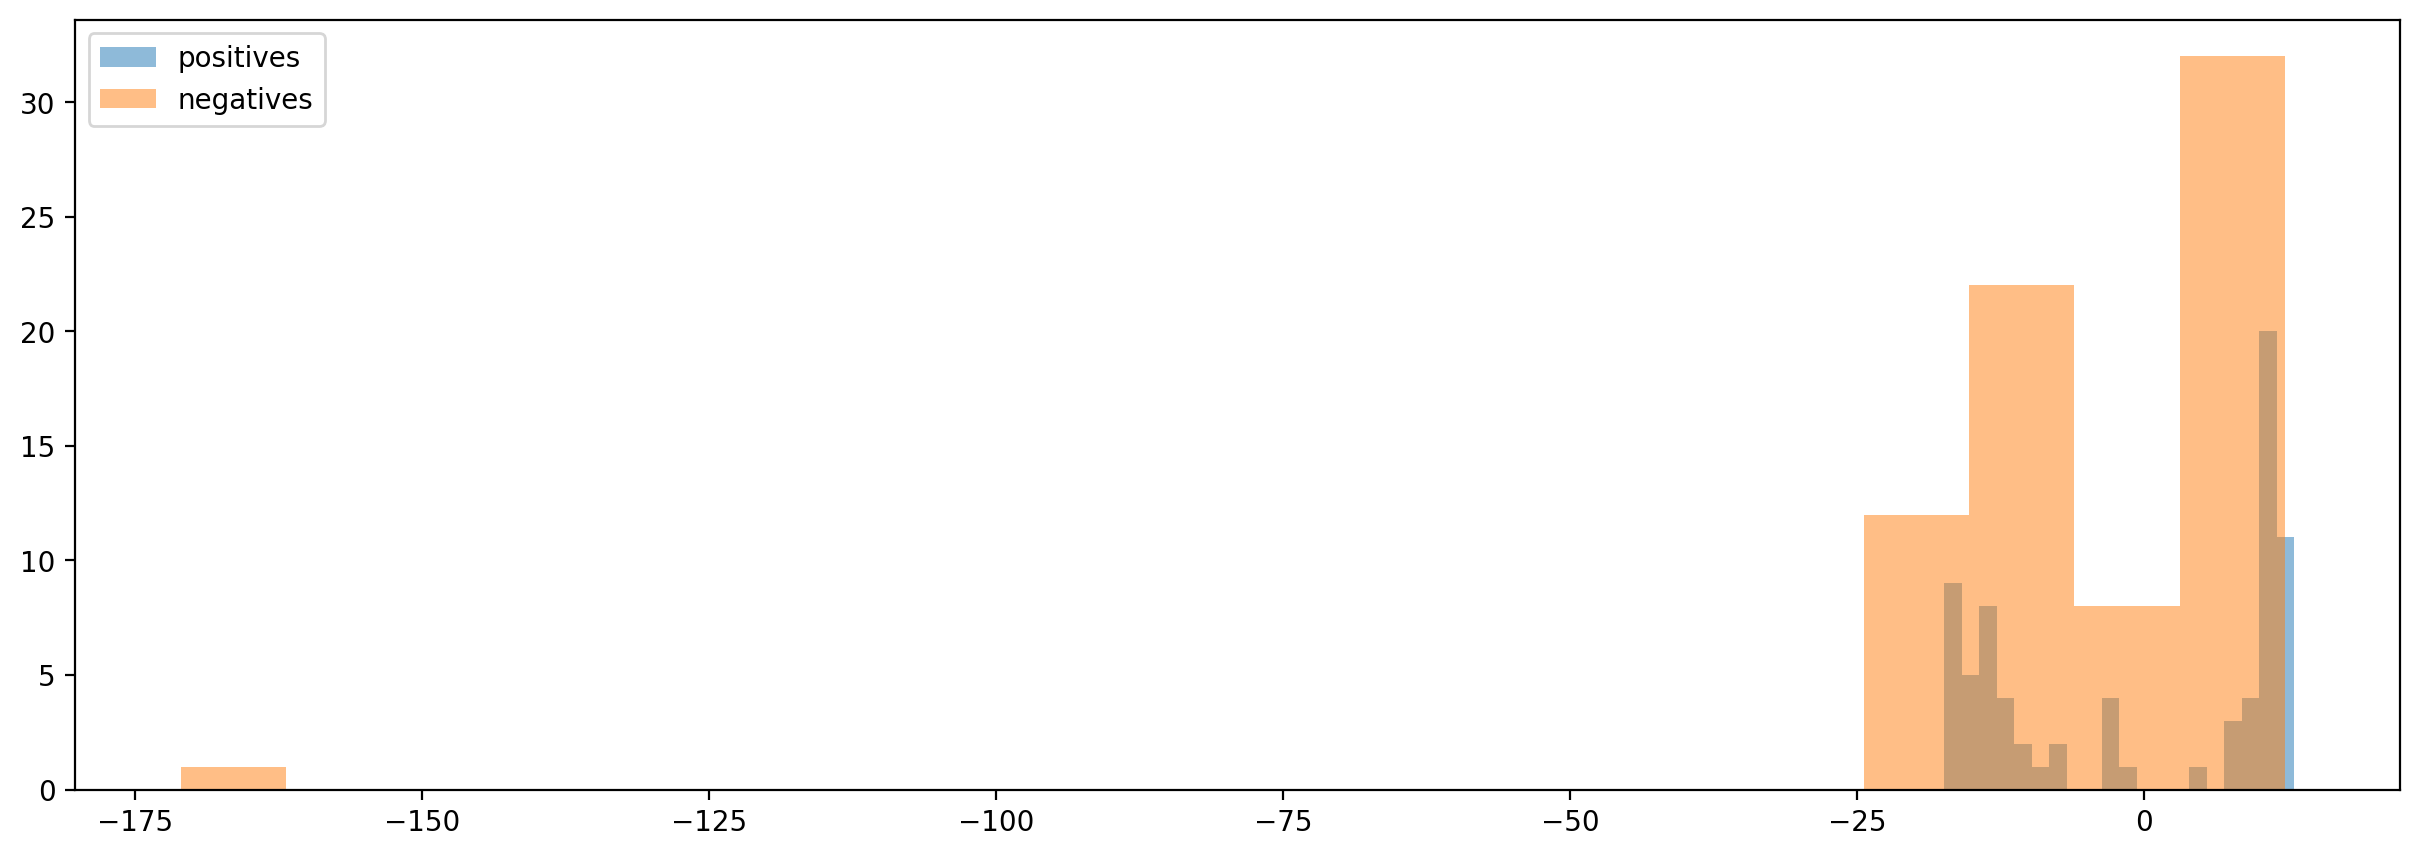

In [49]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_100 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_100

Training size 125

In [50]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [51]:
emb_train_125 = model.embed(labels_trains['train_size_125'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [52]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [53]:
emb_train_125 = torch.tensor(emb_train_125, dtype=torch.float32)
# Check the shape of the embeddings
emb_val = torch.tensor(emb_val, dtype=torch.float32)
print(f"Original shape of emb_train: {emb_train_125.shape}")

height, width = 32, 16  # Ensure height * width = 512
emb_train_125 = emb_train_125.view(emb_train_125.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_100: {emb_train_125.shape}")

Original shape of emb_train: torch.Size([250, 512])
Reshaped emb_train_100: torch.Size([250, 1, 32, 16])


In [54]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [55]:
emb_train_125 = emb_train_125.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [56]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [57]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [58]:
quick_fit(model.network, emb_train_125, labels_trains['train_size_125'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 8.568034536438063e-05, Val Loss: 4.032818794250488
val AU ROC: 0.586
val MAP: 0.586
Epoch 200/1000, Loss: 5.3680465498473495e-05, Val Loss: 4.073987007141113
val AU ROC: 0.576
val MAP: 0.576
Epoch 300/1000, Loss: 3.839235068880953e-05, Val Loss: 4.132157325744629
val AU ROC: 0.573
val MAP: 0.573
Epoch 400/1000, Loss: 2.894065073633101e-05, Val Loss: 4.1913981437683105
val AU ROC: 0.566
val MAP: 0.566
Epoch 500/1000, Loss: 2.2499256374430843e-05, Val Loss: 4.252867698669434
val AU ROC: 0.564
val MAP: 0.564
Epoch 600/1000, Loss: 1.8040880604530685e-05, Val Loss: 4.299954414367676
val AU ROC: 0.564
val MAP: 0.564
Epoch 700/1000, Loss: 1.4791877219977323e-05, Val Loss: 4.350151538848877
val AU ROC: 0.566
val MAP: 0.566
Epoch 800/1000, Loss: 1.236797652381938e-05, Val Loss: 4.397792339324951
val AU ROC: 0.566
val MAP: 0.566
Epoch 900/1000, Loss: 1.0505757927603554e-05, Val Loss: 4.435631275177002
val AU ROC: 0.567
val MAP: 0.567
Epoch 1000/1000, Loss: 9.034414688358083

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/3376882458.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5992888888888889

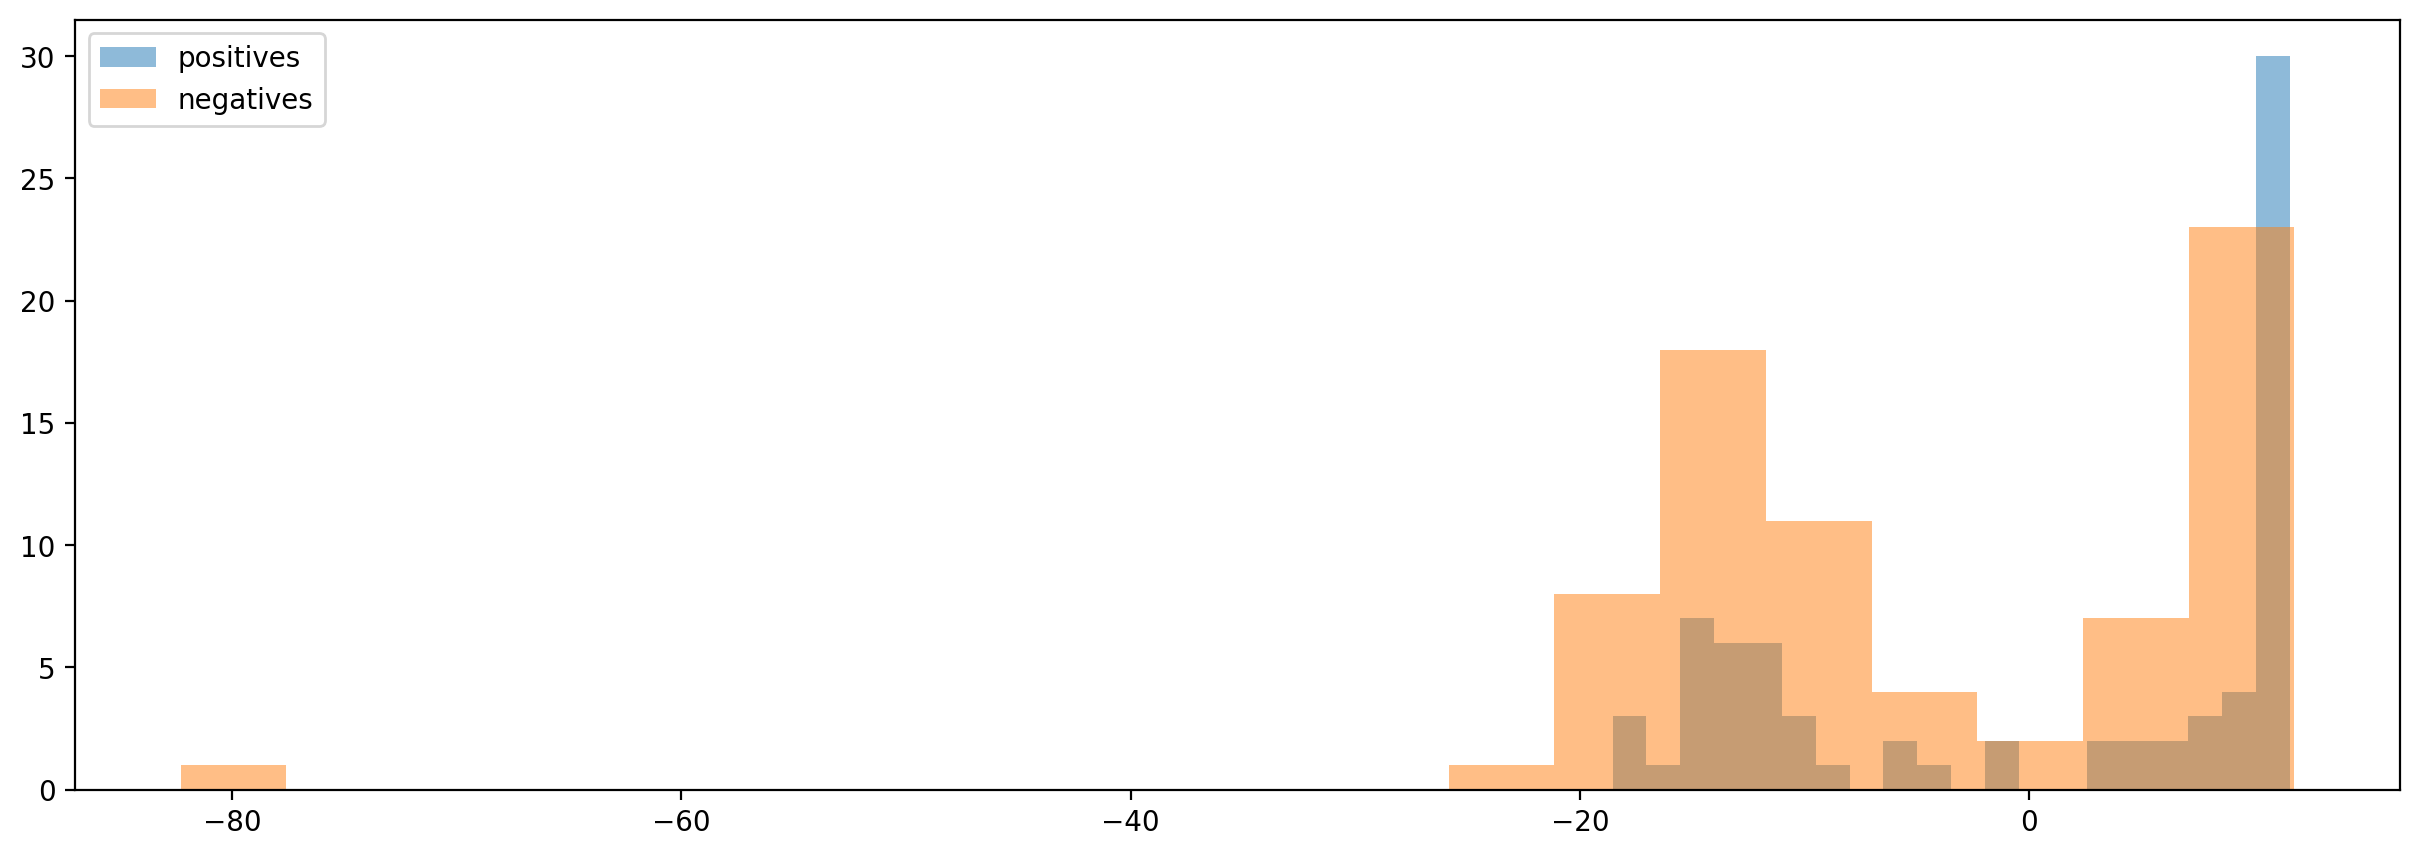

In [59]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_125 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_125

Training size 150

In [60]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [61]:
emb_train_150 = model.embed(labels_trains['train_size_150'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [62]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [63]:
emb_train_150 = torch.tensor(emb_train_150, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_150.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_150 = emb_train_150.view(emb_train_150.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)
# Verify the reshaped embeddings
print(f"Reshaped emb_train_150: {emb_train_150.shape}")

Original shape of emb_train: torch.Size([300, 512])
Reshaped emb_train_150: torch.Size([300, 1, 32, 16])


In [64]:
emb_train_150 = emb_train_150.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [65]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [66]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [67]:
quick_fit(model.network, emb_train_150, labels_trains['train_size_150'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 5.406451236922294e-05, Val Loss: 4.682615756988525
val AU ROC: 0.557
val MAP: 0.557
Epoch 200/1000, Loss: 3.3341504604322836e-05, Val Loss: 4.8181986808776855
val AU ROC: 0.564
val MAP: 0.564
Epoch 300/1000, Loss: 2.350208342249971e-05, Val Loss: 4.9245686531066895
val AU ROC: 0.568
val MAP: 0.568
Epoch 400/1000, Loss: 1.755018820404075e-05, Val Loss: 5.013401985168457
val AU ROC: 0.574
val MAP: 0.574
Epoch 500/1000, Loss: 1.3681888958672062e-05, Val Loss: 5.091185569763184
val AU ROC: 0.577
val MAP: 0.577
Epoch 600/1000, Loss: 1.0959193787130062e-05, Val Loss: 5.157963752746582
val AU ROC: 0.578
val MAP: 0.578
Epoch 700/1000, Loss: 8.988826266431715e-06, Val Loss: 5.213563442230225
val AU ROC: 0.581
val MAP: 0.581
Epoch 800/1000, Loss: 7.497857495764038e-06, Val Loss: 5.262668609619141
val AU ROC: 0.582
val MAP: 0.582
Epoch 900/1000, Loss: 6.3403567764908075e-06, Val Loss: 5.307027816772461
val AU ROC: 0.593
val MAP: 0.593
Epoch 1000/1000, Loss: 5.438846073957393

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/1953958238.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5685333333333333

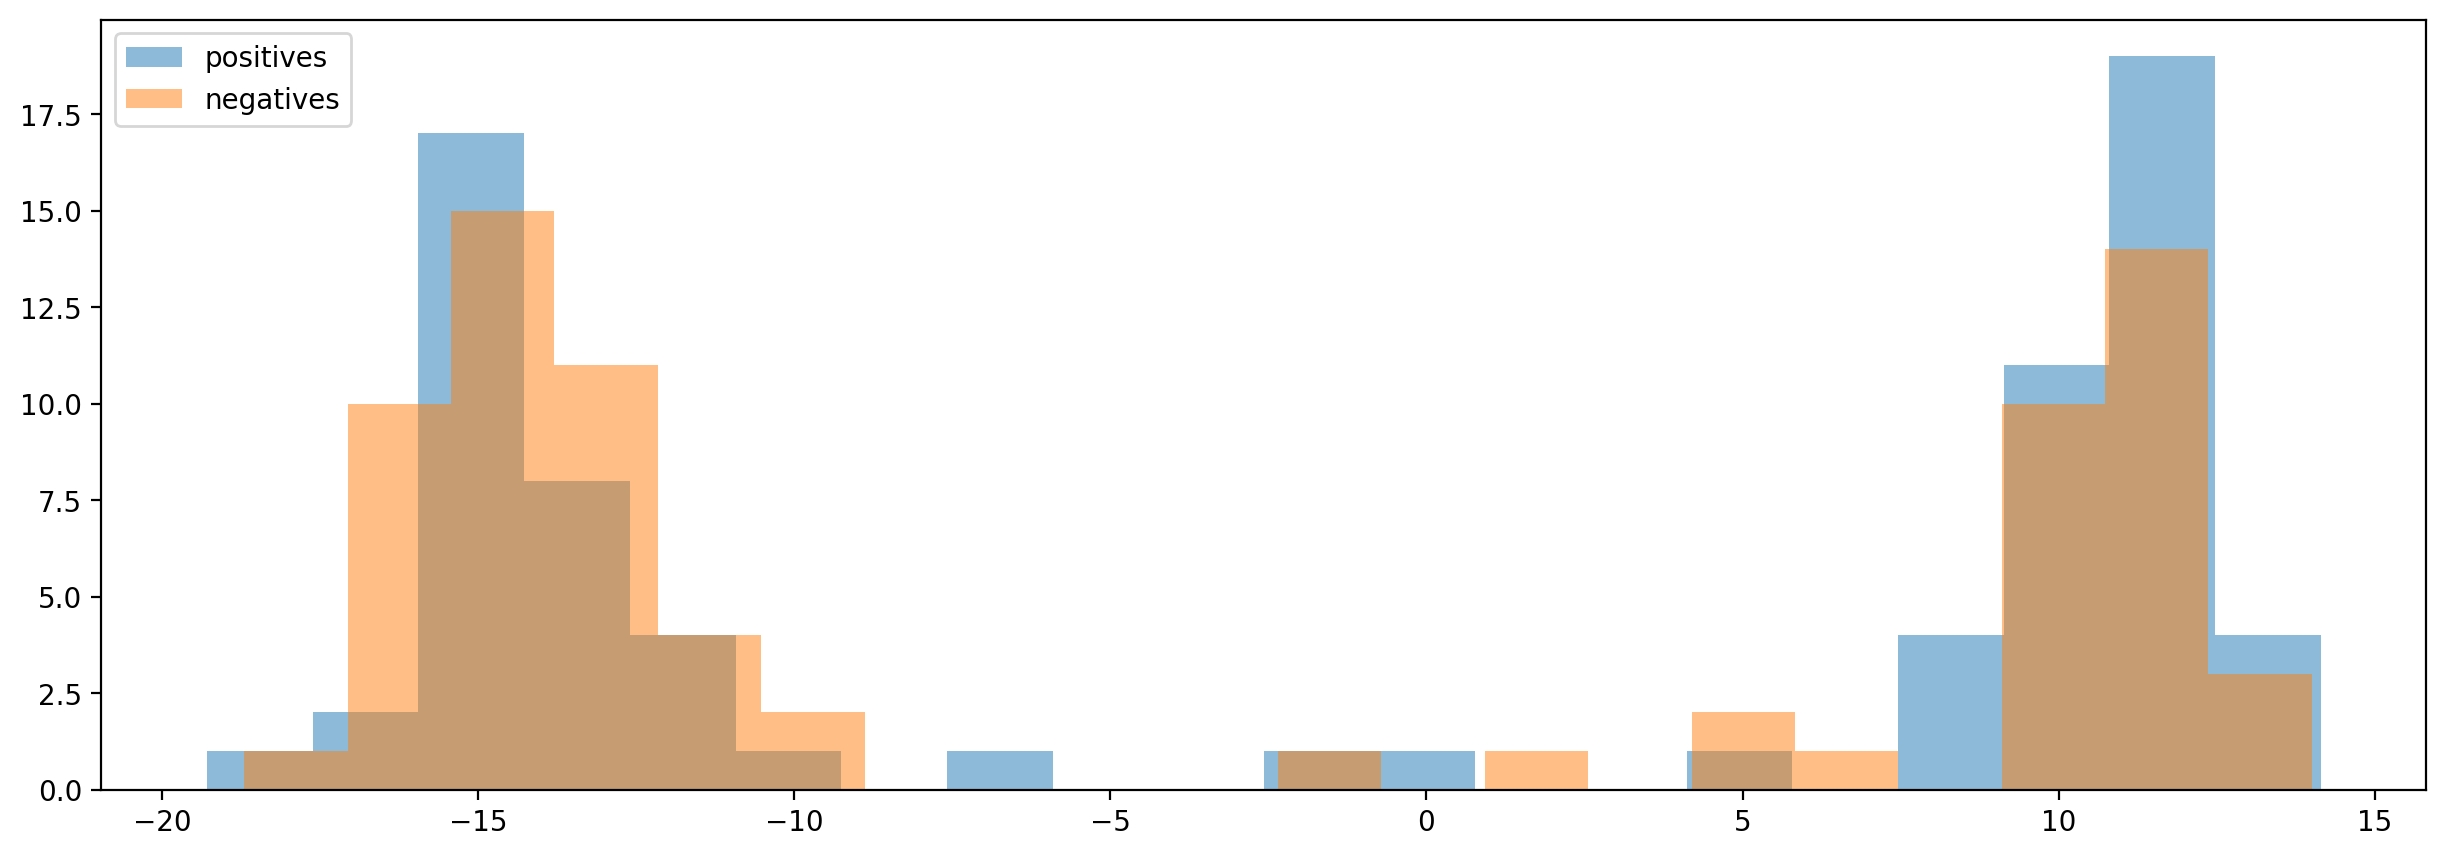

In [68]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_150 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_150

Training size 175

In [69]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [70]:
emb_train_175 = model.embed(labels_trains['train_size_175'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/11 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [71]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [72]:
emb_train_175 = torch.tensor(emb_train_175, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_175.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_175 = emb_train_175.view(emb_train_175.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_175: {emb_train_175.shape}")

Original shape of emb_train: torch.Size([350, 512])
Reshaped emb_train_175: torch.Size([350, 1, 32, 16])


In [73]:
emb_train_175 = emb_train_175.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [74]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [75]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [76]:
quick_fit(model.network, emb_train_175, labels_trains['train_size_175'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 4.640733459382318e-05, Val Loss: 4.7142653465271
val AU ROC: 0.588
val MAP: 0.588
Epoch 200/1000, Loss: 2.7176274670637213e-05, Val Loss: 4.905008792877197
val AU ROC: 0.583
val MAP: 0.583
Epoch 300/1000, Loss: 1.9502640498103574e-05, Val Loss: 5.006967067718506
val AU ROC: 0.575
val MAP: 0.575
Epoch 400/1000, Loss: 1.4982849279476795e-05, Val Loss: 5.086750507354736
val AU ROC: 0.565
val MAP: 0.565
Epoch 500/1000, Loss: 1.1929445463465527e-05, Val Loss: 5.152497291564941
val AU ROC: 0.558
val MAP: 0.558
Epoch 600/1000, Loss: 9.746564501256216e-06, Val Loss: 5.209914207458496
val AU ROC: 0.558
val MAP: 0.558
Epoch 700/1000, Loss: 8.124041414703242e-06, Val Loss: 5.257600784301758
val AU ROC: 0.560
val MAP: 0.560
Epoch 800/1000, Loss: 6.874987775518093e-06, Val Loss: 5.300470352172852
val AU ROC: 0.556
val MAP: 0.556
Epoch 900/1000, Loss: 5.890797638130607e-06, Val Loss: 5.340022563934326
val AU ROC: 0.562
val MAP: 0.562
Epoch 1000/1000, Loss: 5.096652785141487e-06

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/2433222695.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5532444444444444

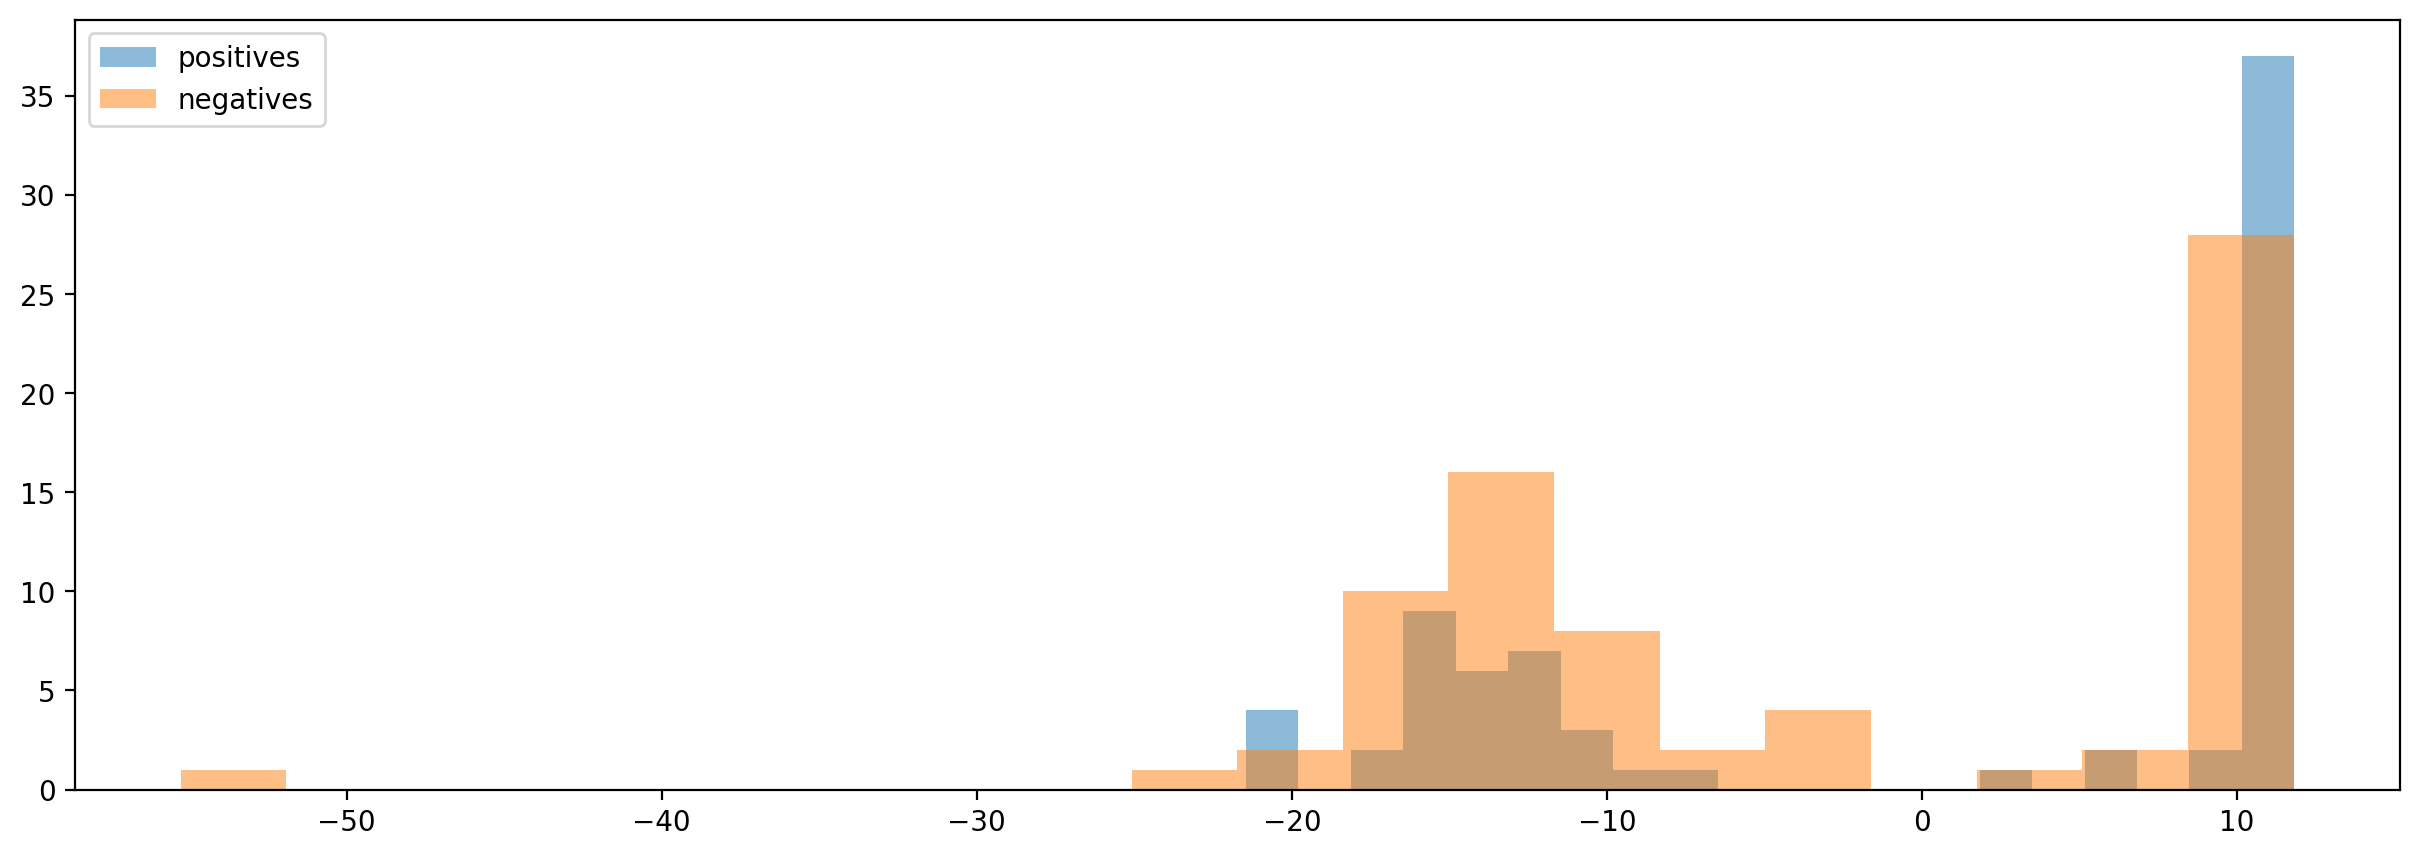

In [77]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_175 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_175

Training size 200

In [78]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [79]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [80]:
emb_train_200 = model.embed(labels_trains['train_size_200'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/13 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [81]:
emb_train_200 = torch.tensor(emb_train_200, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_200.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_200 = emb_train_200.view(emb_train_200.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_200: {emb_train_200.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([400, 512])
Reshaped emb_train_200: torch.Size([400, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [82]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [83]:
emb_train_200 = emb_train_200.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [84]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [85]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [86]:
quick_fit(model.network, emb_train_200, labels_trains['train_size_200'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 7.682271098019555e-05, Val Loss: 4.529831886291504
val AU ROC: 0.555
val MAP: 0.555
Epoch 200/1000, Loss: 4.5926244638394564e-05, Val Loss: 4.666072368621826
val AU ROC: 0.541
val MAP: 0.541
Epoch 300/1000, Loss: 3.232021481380798e-05, Val Loss: 4.763537406921387
val AU ROC: 0.535
val MAP: 0.535
Epoch 400/1000, Loss: 2.42326277657412e-05, Val Loss: 4.839515686035156
val AU ROC: 0.532
val MAP: 0.532
Epoch 500/1000, Loss: 1.891916872409638e-05, Val Loss: 4.908529281616211
val AU ROC: 0.529
val MAP: 0.529
Epoch 600/1000, Loss: 1.5209272532956675e-05, Val Loss: 4.967099189758301
val AU ROC: 0.530
val MAP: 0.530
Epoch 700/1000, Loss: 1.2496328054112382e-05, Val Loss: 5.019969940185547
val AU ROC: 0.530
val MAP: 0.530
Epoch 800/1000, Loss: 1.0456410564074758e-05, Val Loss: 5.068710803985596
val AU ROC: 0.531
val MAP: 0.531
Epoch 900/1000, Loss: 8.854813131620176e-06, Val Loss: 5.116328239440918
val AU ROC: 0.524
val MAP: 0.524
Epoch 1000/1000, Loss: 7.53268068365287e-06

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/1978695488.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5564444444444444

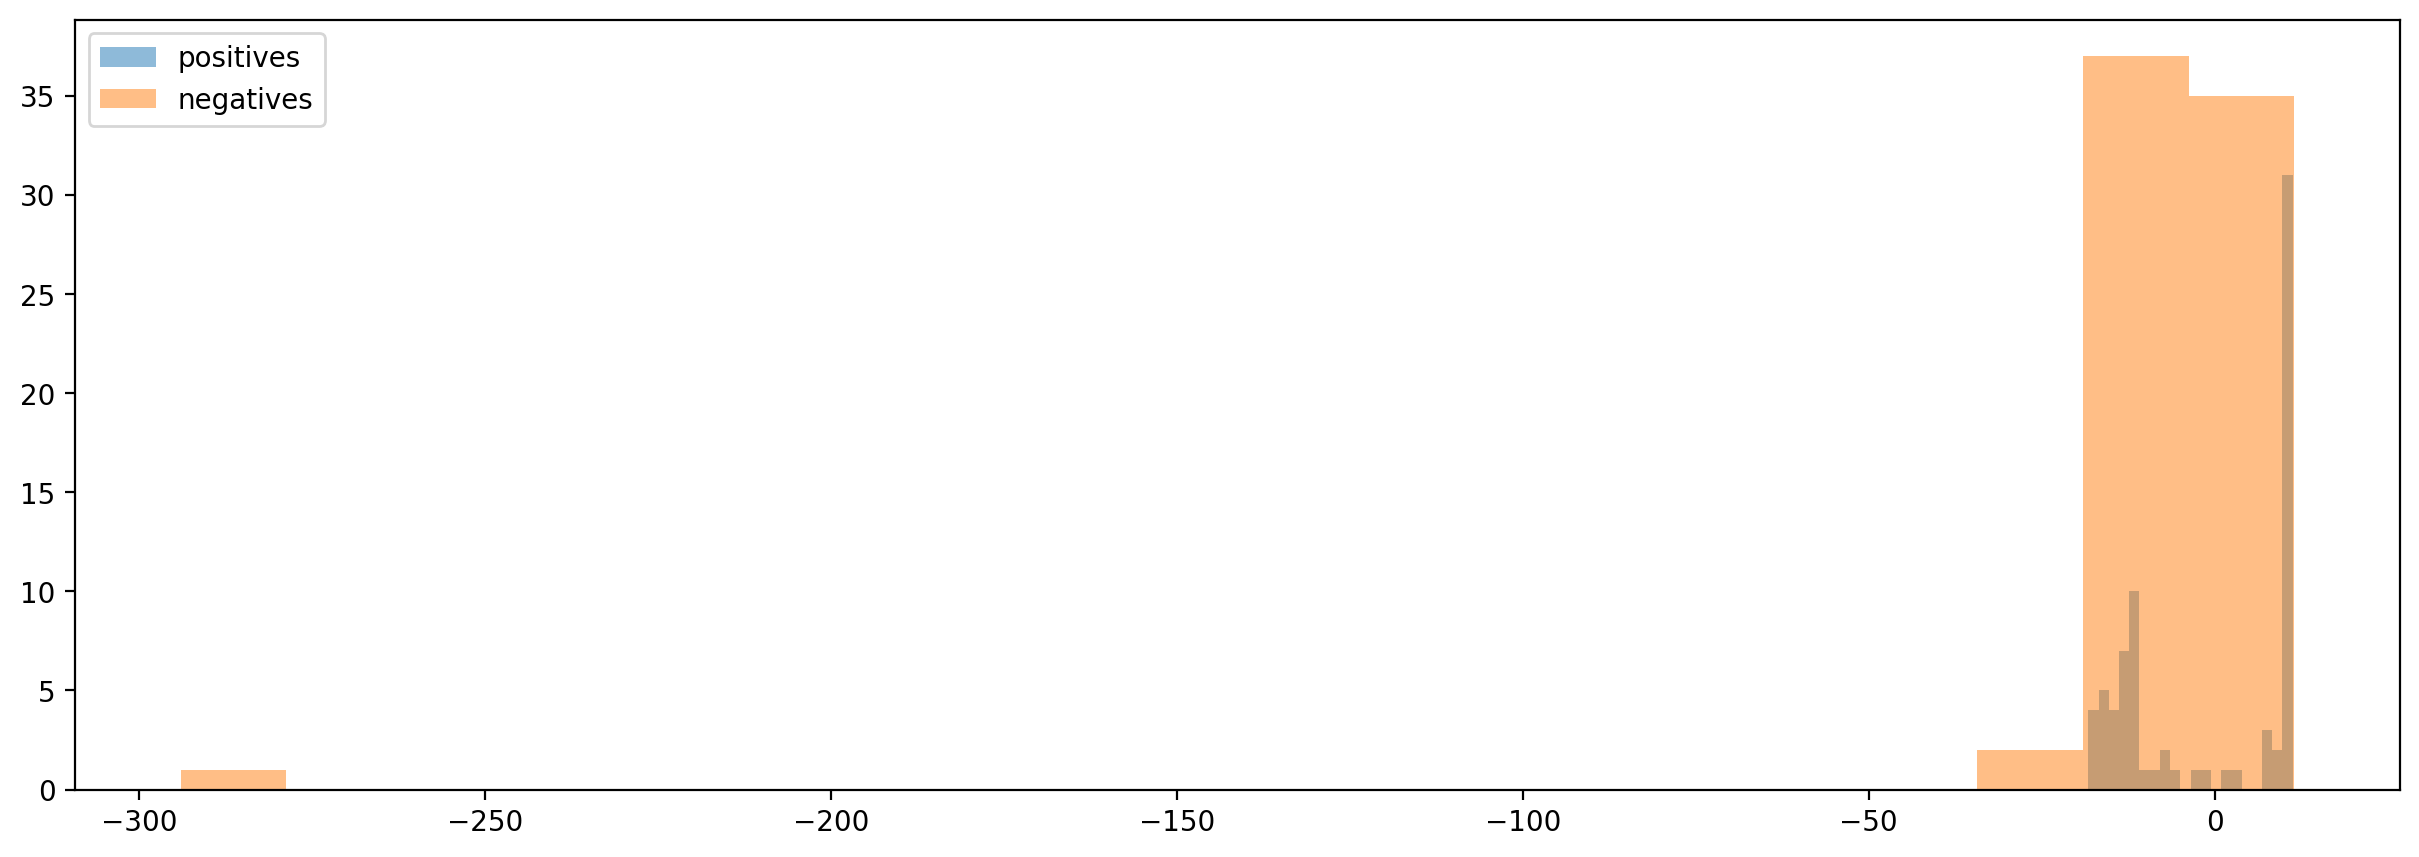

In [87]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_200 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_200

Training size 225

In [88]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [89]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [90]:
emb_train_225 = model.embed(labels_trains['train_size_225'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [91]:
emb_train_225 = torch.tensor(emb_train_225, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_225.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_225 = emb_train_225.view(emb_train_225.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_225: {emb_train_225.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([450, 512])
Reshaped emb_train_225: torch.Size([450, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [92]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [93]:
emb_train_225 = emb_train_225.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [94]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [96]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [95]:
quick_fit(model.network, emb_train_225, labels_trains['train_size_225'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 2.8205620765220374e-05, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 200/1000, Loss: 1.9109356799162924e-05, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 300/1000, Loss: 1.481642266298877e-05, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 400/1000, Loss: 1.2104233974241652e-05, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 500/1000, Loss: 1.020832405629335e-05, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 600/1000, Loss: 8.74155193741899e-06, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 700/1000, Loss: 7.630196705576964e-06, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 800/1000, Loss: 6.712064532621298e-06, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 900/1000, Loss: 5.966058779449668e-06, Val Loss: nan
val AU ROC: nan
val MAP: nan
Epoch 1000/1000, Loss: 5.3436297093867324e-06, Val Loss: nan
val AU ROC: nan
val MAP: nan
Training complete


/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/1751666026.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5504

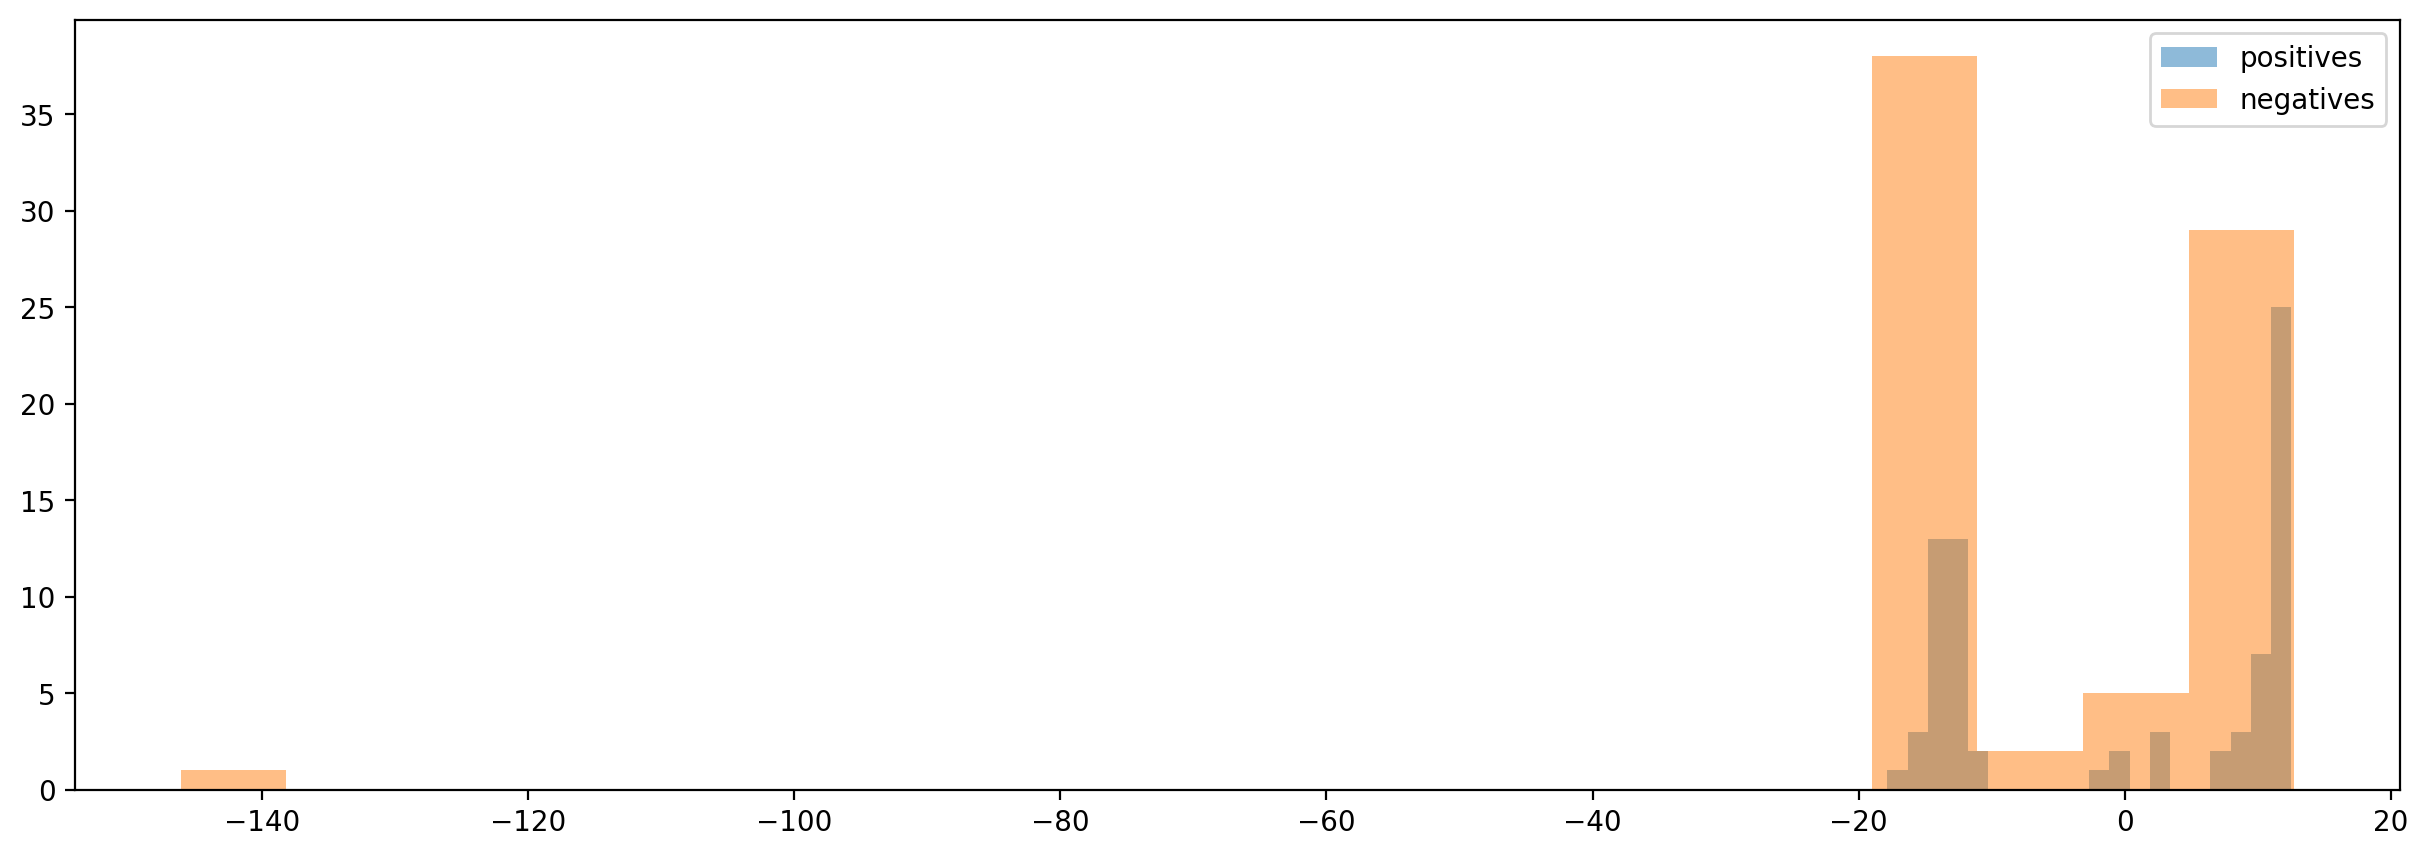

In [97]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_225 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_225

Training size 250

In [98]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [99]:
emb_train_250 = model.embed(labels_trains['train_size_250'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [100]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [101]:
emb_train_250 = torch.tensor(emb_train_250, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_250.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_250 = emb_train_250.view(emb_train_250.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_250: {emb_train_250.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([500, 512])
Reshaped emb_train_250: torch.Size([500, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [102]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [103]:
emb_train_250 = emb_train_250.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [104]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [105]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [106]:
quick_fit(model.network, emb_train_250, labels_trains['train_size_250'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 6.568909884663299e-05, Val Loss: 4.908997535705566
val AU ROC: 0.551
val MAP: 0.551
Epoch 200/1000, Loss: 3.995969018433243e-05, Val Loss: 5.019704818725586
val AU ROC: 0.557
val MAP: 0.557
Epoch 300/1000, Loss: 2.812455568346195e-05, Val Loss: 5.096670627593994
val AU ROC: 0.561
val MAP: 0.561
Epoch 400/1000, Loss: 2.127528568962589e-05, Val Loss: 5.154783725738525
val AU ROC: 0.569
val MAP: 0.569
Epoch 500/1000, Loss: 1.6797932403278537e-05, Val Loss: 5.204968452453613
val AU ROC: 0.572
val MAP: 0.572
Epoch 600/1000, Loss: 1.3644970749737695e-05, Val Loss: 5.247049808502197
val AU ROC: 0.572
val MAP: 0.572
Epoch 700/1000, Loss: 1.131479803007096e-05, Val Loss: 5.286087512969971
val AU ROC: 0.574
val MAP: 0.574
Epoch 800/1000, Loss: 9.548100024403539e-06, Val Loss: 5.322649002075195
val AU ROC: 0.574
val MAP: 0.574
Epoch 900/1000, Loss: 8.155123396136332e-06, Val Loss: 5.356189727783203
val AU ROC: 0.570
val MAP: 0.570
Epoch 1000/1000, Loss: 7.050865406199591e-06

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/3342173857.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5534222222222223

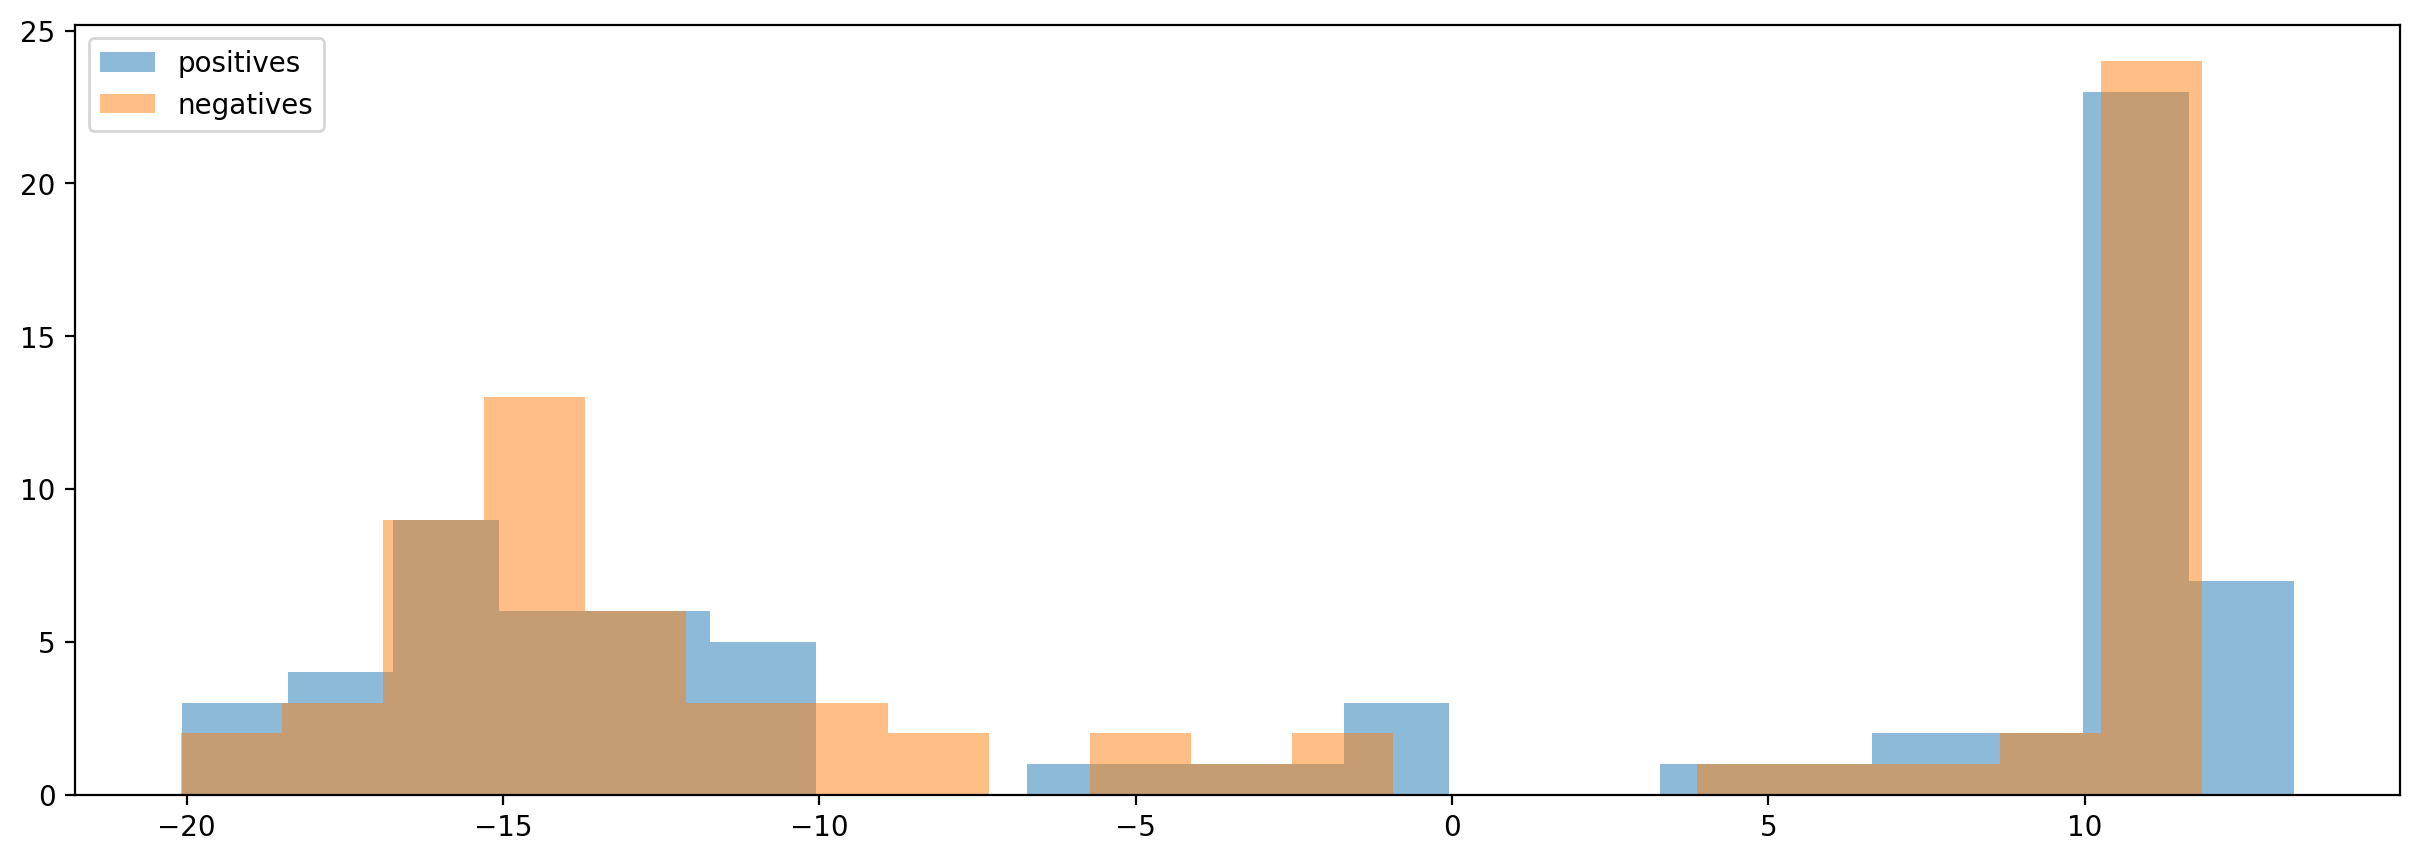

In [107]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_250 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_250

Training size 275

In [108]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [109]:
emb_train_275 = model.embed(labels_trains['train_size_275'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/18 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [110]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [111]:
emb_train_275 = torch.tensor(emb_train_275, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_275.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_275 = emb_train_275.view(emb_train_275.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_275: {emb_train_275.shape}")


Original shape of emb_train: torch.Size([550, 512])
Reshaped emb_train_275: torch.Size([550, 1, 32, 16])


In [112]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [113]:
emb_train_275 = emb_train_275.repeat(1, 3, 1, 1) 
emb_val = emb_val.repeat(1, 3, 1, 1)

In [114]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [115]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [116]:
quick_fit(model.network, emb_train_275, labels_trains['train_size_275'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 5.540049824048765e-05, Val Loss: 4.565520763397217
val AU ROC: 0.527
val MAP: 0.527
Epoch 200/1000, Loss: 3.336007648613304e-05, Val Loss: 4.6972503662109375
val AU ROC: 0.530
val MAP: 0.530
Epoch 300/1000, Loss: 2.3978716853889637e-05, Val Loss: 4.805385112762451
val AU ROC: 0.535
val MAP: 0.535
Epoch 400/1000, Loss: 1.8425680536893196e-05, Val Loss: 4.872471332550049
val AU ROC: 0.532
val MAP: 0.532
Epoch 500/1000, Loss: 1.4849881154077593e-05, Val Loss: 4.943307399749756
val AU ROC: 0.533
val MAP: 0.533
Epoch 600/1000, Loss: 1.23397212519194e-05, Val Loss: 5.004003047943115
val AU ROC: 0.533
val MAP: 0.533
Epoch 700/1000, Loss: 1.0445495718158782e-05, Val Loss: 5.054754257202148
val AU ROC: 0.533
val MAP: 0.533
Epoch 800/1000, Loss: 8.965284905571025e-06, Val Loss: 5.100830078125
val AU ROC: 0.533
val MAP: 0.533
Epoch 900/1000, Loss: 7.782725333527196e-06, Val Loss: 5.142198085784912
val AU ROC: 0.532
val MAP: 0.532
Epoch 1000/1000, Loss: 6.819379905209644e-06,

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/872787565.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5223111111111112

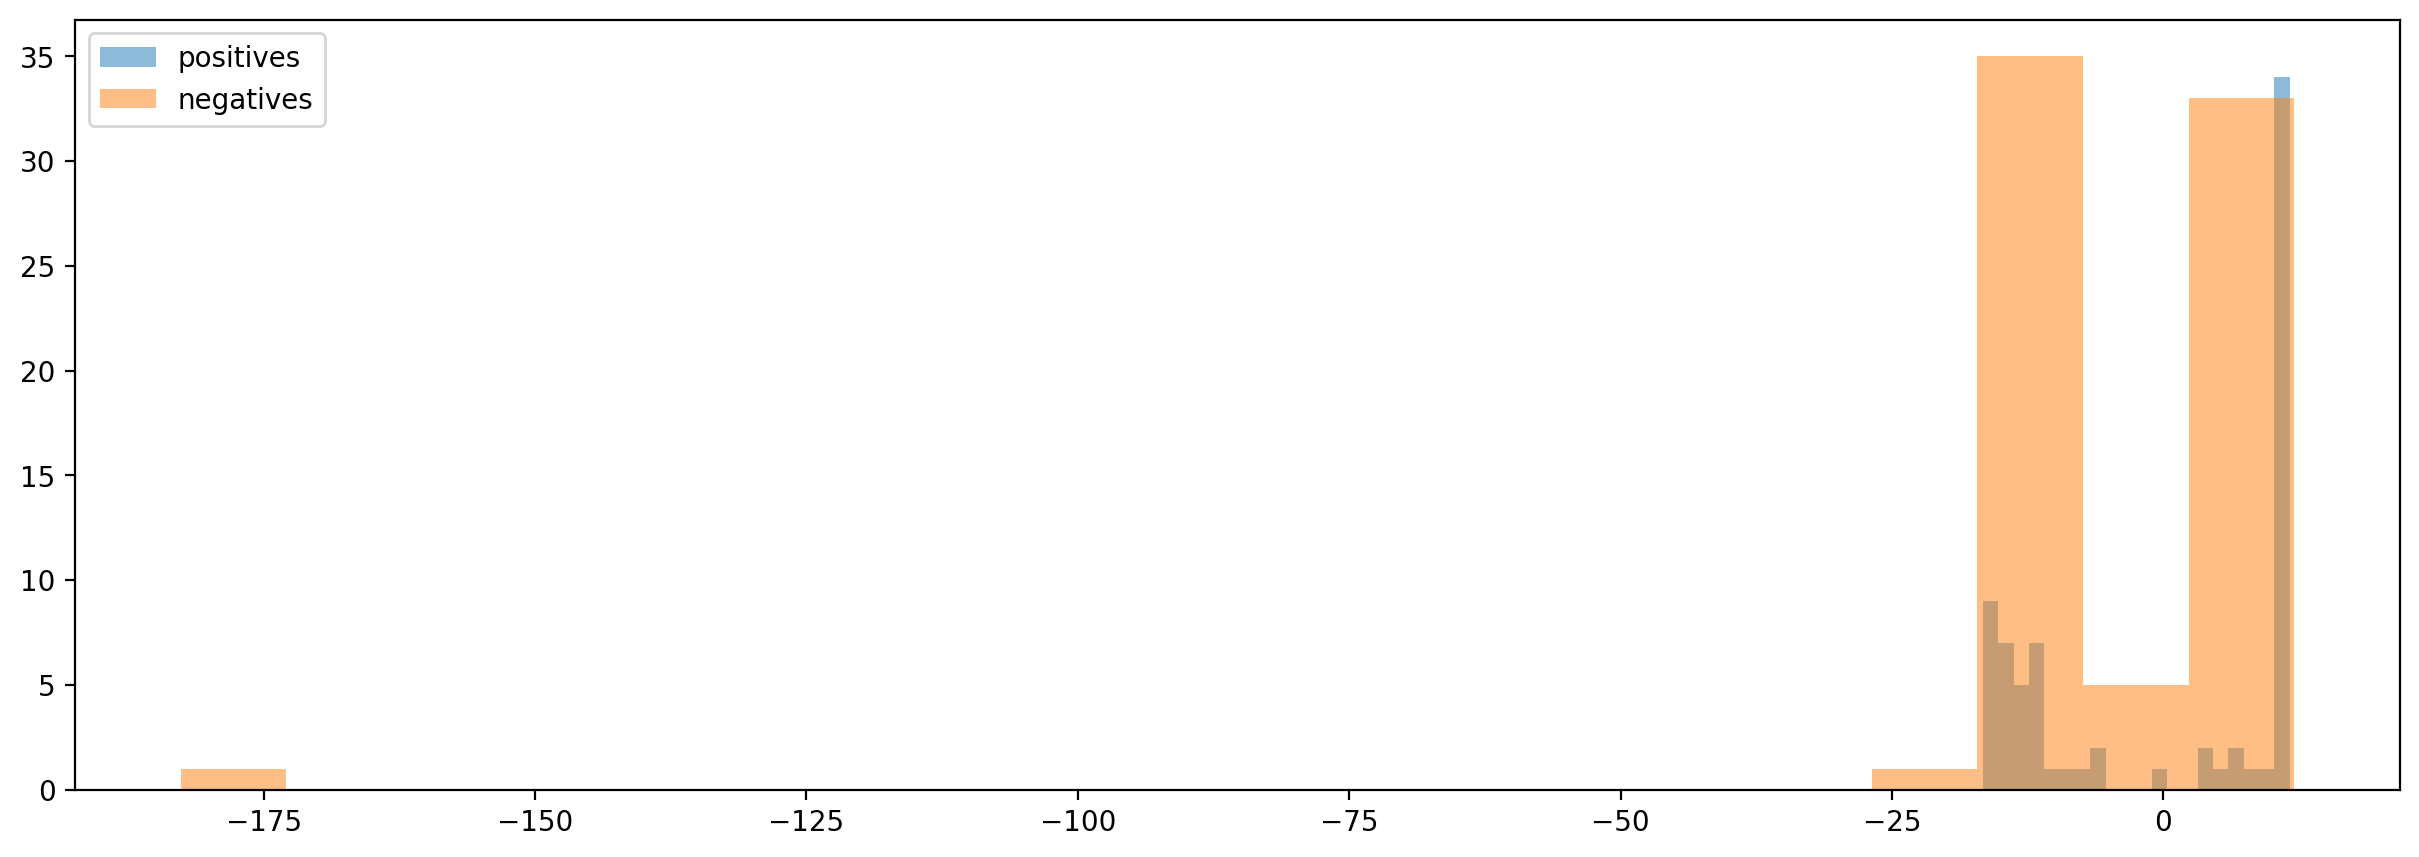

In [117]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_275 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_275

Training size 300

In [118]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [119]:
emb_train_300 = model.embed(labels_trains['train_size_300'], return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/19 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [120]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.975 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1713: UserWarning: audio object has zero samples
  warnings.warn(error_msg)


In [121]:
emb_train_300 = torch.tensor(emb_train_300, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)
# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train_300.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train_300 = emb_train_300.view(emb_train_300.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train_300: {emb_train_300.shape}")


Original shape of emb_train: torch.Size([600, 512])
Reshaped emb_train_300: torch.Size([600, 1, 32, 16])


In [122]:
if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [123]:
emb_val = emb_val.repeat(1, 3, 1, 1)
emb_train_300 = emb_train_300.repeat(1, 3, 1, 1) 

In [124]:
model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)

In [125]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0

In [126]:
quick_fit(model.network, emb_train_300, labels_trains['train_size_300'].values, emb_val, labels_val.values, steps=1000)

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


Epoch 100/1000, Loss: 8.835711923893541e-05, Val Loss: 4.104510307312012
val AU ROC: 0.553
val MAP: 0.553
Epoch 200/1000, Loss: 5.25432187714614e-05, Val Loss: 4.253661155700684
val AU ROC: 0.547
val MAP: 0.547
Epoch 300/1000, Loss: 3.675050538731739e-05, Val Loss: 4.356471538543701
val AU ROC: 0.545
val MAP: 0.545
Epoch 400/1000, Loss: 2.760810821200721e-05, Val Loss: 4.436901569366455
val AU ROC: 0.548
val MAP: 0.548
Epoch 500/1000, Loss: 2.1766667487099767e-05, Val Loss: 4.502253532409668
val AU ROC: 0.545
val MAP: 0.545
Epoch 600/1000, Loss: 1.7701604519970715e-05, Val Loss: 4.5585036277771
val AU ROC: 0.537
val MAP: 0.537
Epoch 700/1000, Loss: 1.4720168110216036e-05, Val Loss: 4.609585762023926
val AU ROC: 0.537
val MAP: 0.537
Epoch 800/1000, Loss: 1.2475333278416656e-05, Val Loss: 4.655351638793945
val AU ROC: 0.534
val MAP: 0.534
Epoch 900/1000, Loss: 1.0728514098445885e-05, Val Loss: 4.698773384094238
val AU ROC: 0.529
val MAP: 0.529
Epoch 1000/1000, Loss: 9.33302999328589e-06,

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_4790/3752346880.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()


0.5221333333333333

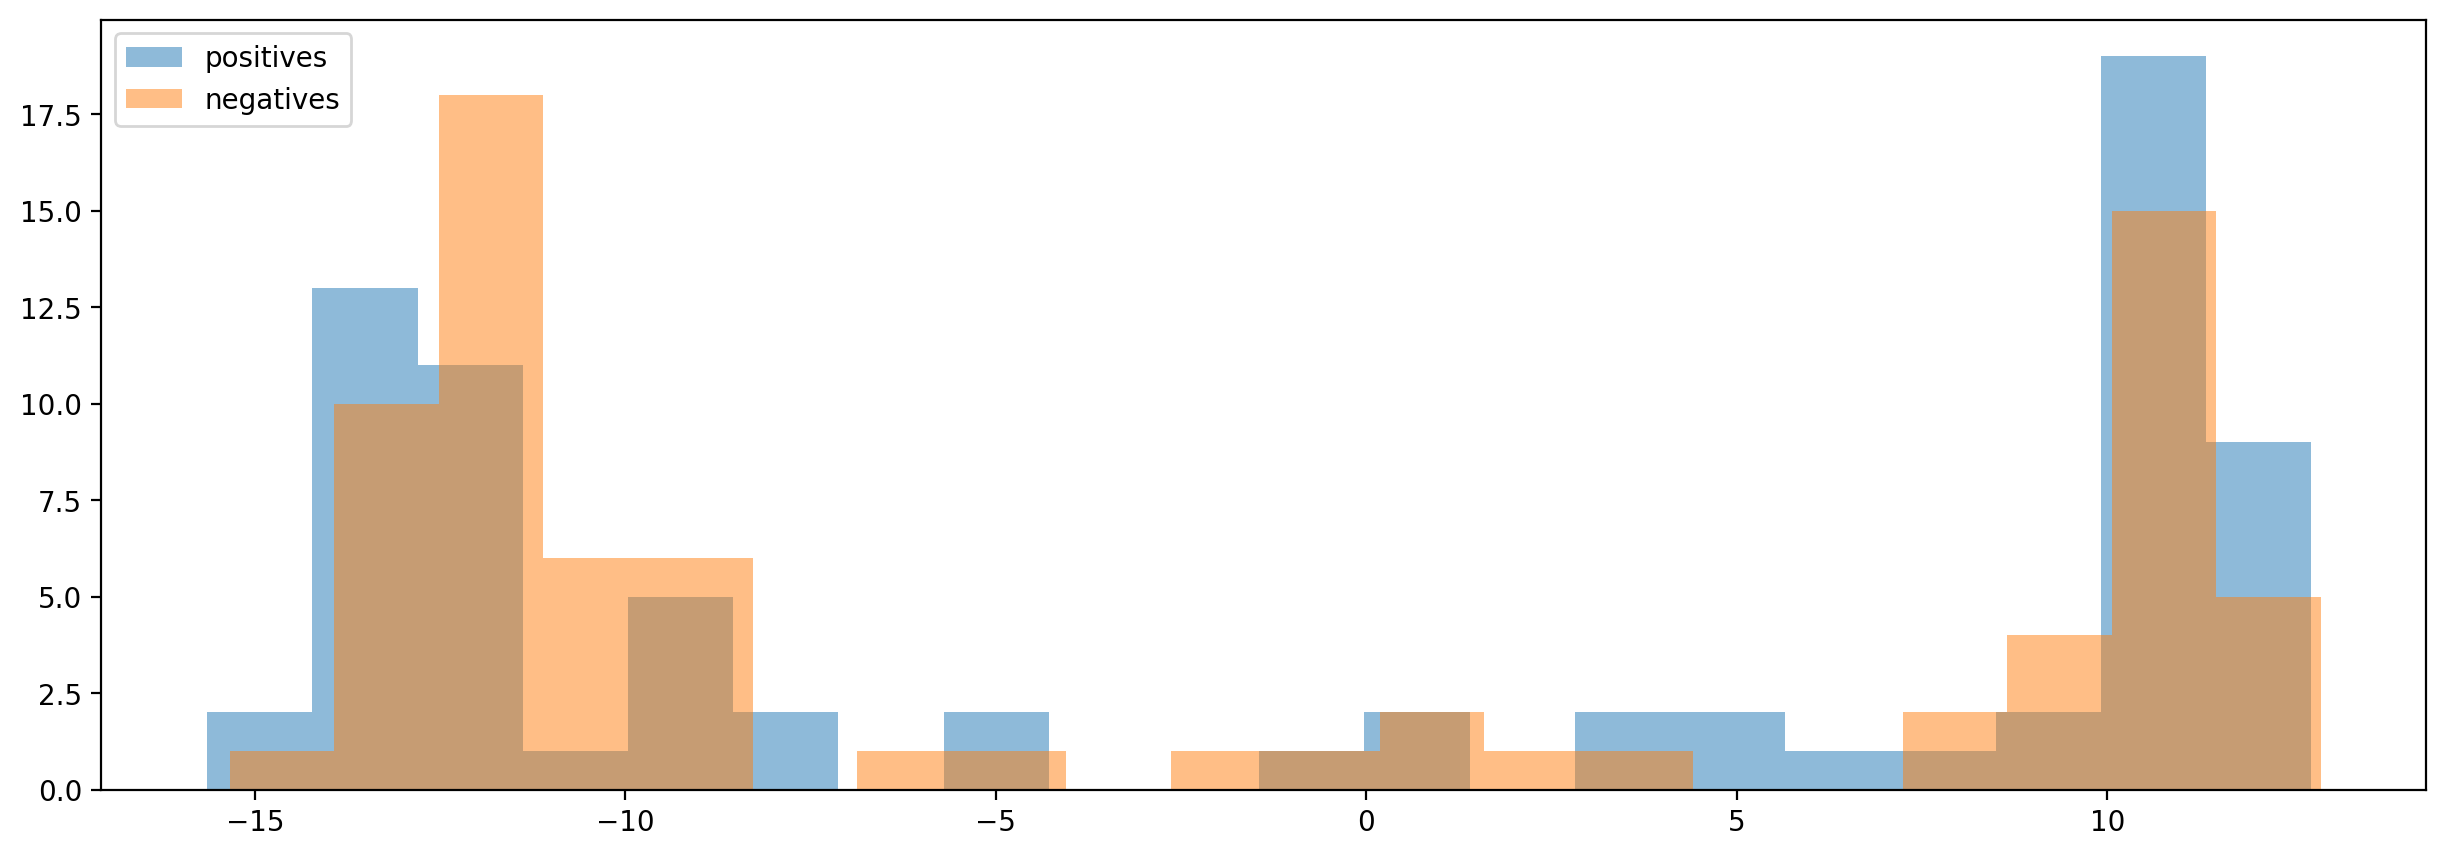

In [127]:
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score_300 = roc_auc_score(labels_val.values,preds,average=None)
roc_auc_score_300

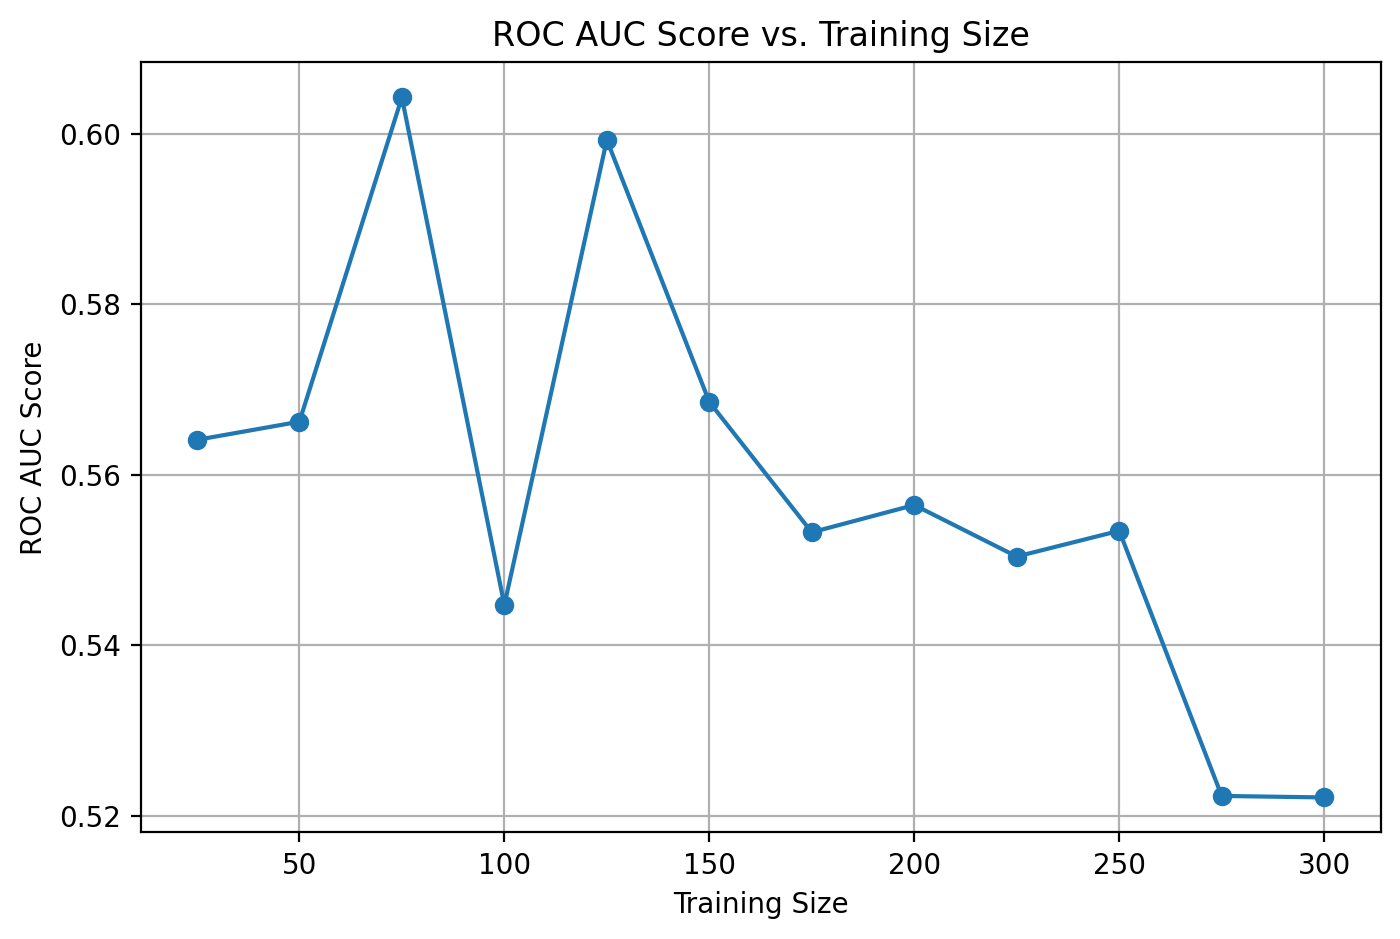

In [128]:
training_sizes = []
roc_auc_scores = []

# Iterate over training sizes and collect the scores
for size in range(25, 301, 25):
    score = eval(f"roc_auc_score_{size}")
    training_sizes.append(size)
    roc_auc_scores.append(score)

# Create a DataFrame
df = pd.DataFrame({"Training Size": training_sizes, "ROC AUC Score": roc_auc_scores})


# Plot a line plot
plt.figure(figsize=(8, 5))
plt.plot(df["Training Size"], df["ROC AUC Score"], marker='o', linestyle='-')
plt.title("ROC AUC Score vs. Training Size")
plt.xlabel("Training Size")
plt.ylabel("ROC AUC Score")
plt.grid(True)
plt.show()